# *Lending Club Case Study*
---

# *Business Problem*

##### 1) The primary challenge for a consumer finance company is to mitigate financial losses caused by 'risky' loan applicants who default, referred to as 'charged-off' customers.
##### 2) It is expected that the case study identifies patterns which indicate if a person is likely to default, enabling the company to refine its loan approval process

---

# Load respective Python libs and supress warning

## Load Python libs

In [1]:
# Import necessary modules
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",300)
pd.set_option("display.max_rows",300)

## Read data and explorer data

In [2]:
# read the data set from dataset folder, 0th row being header. To avoid warning, added low_memorf flag
df = pd.read_csv('.\dataset\loan.csv',header=0, low_memory=False)

In [3]:
# Let us understand the number of columns, type and number of records
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    id                              int64  
 1    member_id                       int64  
 2    loan_amnt                       int64  
 3    funded_amnt                     int64  
 4    funded_amnt_inv                 float64
 5    term                            object 
 6    int_rate                        object 
 7    installment                     float64
 8    grade                           object 
 9    sub_grade                       object 
 10   emp_title                       object 
 11   emp_length                      object 
 12   home_ownership                  object 
 13   annual_inc                      float64
 14   verification_status             object 
 15   issue_d                         object 
 16   loan_status                     object 
 17   pymnt_plan

## Understand gaps in data

In [4]:
# Calculate percentage of missing values i.e. nan
missing = round(100 * df.isnull().sum()/len(df.index), 2)
missing.sort_values(ascending = False)

verification_status_joint         100.00
annual_inc_joint                  100.00
mo_sin_old_rev_tl_op              100.00
mo_sin_old_il_acct                100.00
bc_util                           100.00
bc_open_to_buy                    100.00
avg_cur_bal                       100.00
acc_open_past_24mths              100.00
inq_last_12m                      100.00
total_cu_tl                       100.00
inq_fi                            100.00
total_rev_hi_lim                  100.00
all_util                          100.00
max_bal_bc                        100.00
open_rv_24m                       100.00
open_rv_12m                       100.00
il_util                           100.00
total_bal_il                      100.00
mths_since_rcnt_il                100.00
open_il_24m                       100.00
open_il_12m                       100.00
open_il_6m                        100.00
open_acc_6m                       100.00
tot_cur_bal                       100.00
tot_coll_amt    

## Common Definitions

#### Below definitions are used for plotting grpahs to reduce the length of code and increase reusability

In [5]:
def get_IQR_stats(df: pd.DataFrame, iqr_multiplier: float = 1.5) -> dict:
    # Calculate the 25th percentile (first quartile)
    quartile_025 = df.quantile(0.25)
    
    # Calculate the 75th percentile (third quartile)
    quartile_075 = df.quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    iqr = quartile_075 - quartile_025

    # Calculate the lower bound of the IQR range
    IQR_lb = quartile_025 - iqr_multiplier * iqr

    # Calculate the upper bound of the IQR range
    IQR_ub = quartile_075 + iqr_multiplier * iqr

    # Return the IQR statistics as a dictionary
    return {
        'iqr': iqr,
        'quartile_025': quartile_025,
        'quartile_075': quartile_075,
        'IQR_lb': IQR_lb,
        'IQR_ub': IQR_ub
    }

In [6]:
def plot_bar_graph(df: pd.DataFrame, annotate : bool = True,hue_column=None, title : str = None, xlabel : str =None, ylabel: str = None, figsize=(10, 6), x_tick_rotation : int =90, freq_rotation : int =90) -> None:

    # Set the theme of the plot to dark grid
    sns.set_theme(style="darkgrid")

    # Set the figure size
    plt.figure(figsize=figsize)

    # Calculate value counts for the data and extract x and y values for the plot
    y_data = df.value_counts()
    x_data = y_data.index

    # Create a bar plot
    sns.barplot(x=x_data, y=y_data.values, hue=None)

    # Display frequency on top of the bars with rotation
    if annotate:
        for p in plt.gca().patches:
            plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='left', va='bottom', rotation=freq_rotation)

    # Set title and labels
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)

    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation)
    
    # Show the plot
    plt.show()

    # Print normalized value counts (percentages) of the data
    labels = df.value_counts(normalize=True).mul(100).round(1)
    for index, value in zip(labels.index, labels.values): print(f'{index} : {value} %')

In [7]:
def create_boxplot(df: pd.DataFrame, xlabel: str = None, title: str = None, horizontal: bool = True) -> None:
    # Set the theme of the plot to dark grid
    sns.set_theme(style="darkgrid")

    # Set the default figure size
    plt.figure(figsize=(8, 6))

    # Create a horizontal box plot if horizontal is True, otherwise create a vertical box plot
    if horizontal:
        sns.boxplot(y=df, orient='h', palette='Set2')
    else:
        sns.boxplot(x=df, orient='v', palette='Set2')

    # Set the title of the plot if provided
    if title:
        plt.title(title)

    # Set the x-axis label if provided
    plt.xlabel(xlabel, fontsize=12)

    # Set the y-axis label
    plt.ylabel('Values', fontsize=12)

    # Show the plot
    plt.show()


In [8]:
def plot_simple_countplot(df : pd.DataFrame, x_col, figsize=(6, 6)) -> None :
    # Set the figure size
    plt.figure(figsize=figsize)

    # Create a count plot for the specified column in the DataFrame
    bar_plot = sns.countplot(data=df, x=x_col)
    
    # Annotate bars with their respective counts
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'),
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', xytext=(0, 5),
                          textcoords='offset points')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()
    
    # Print normalized value counts (percentages) of the specified column
    print(df[x_col].value_counts(normalize=True).mul(100).round(1).astype(str) + ' %')

In [9]:
def plot_bar_graph_with_cols (df: pd.DataFrame, x_column=None, y_column=None, annotate : bool = True,hue_column=None, title : str = None, xlabel : str =None, ylabel: str = None, figsize=(10, 6), x_tick_rotation : int =90, freq_rotation : int =90) -> None:

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Create a bar plot for the specified columns in the DataFrame
    bar_plot = sns.barplot(x=x_column, y=y_column, hue=hue_column, data=df)
    
    # Annotate bars with their respective counts
    for container in bar_plot.containers:
        for bar in container:
            bar_height = bar.get_height()
            bar_plot.annotate(format(bar_height, '.1f'),
                              xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                              xytext=(-5, 20),  # Offset position
                              textcoords='offset points',
                              ha='center', va='center', fontsize = 10, rotation=90)
       
   # Set title and labels
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=x_tick_rotation)
    
    # Show the plot
    plt.show()

In [10]:
def plot_charged_off_percentage(df : pd.DataFrame, column, stacked=False) -> None :
    # Group by the specified column and loan_status
    grouped_data = df.groupby([column, 'loan_status']).size().unstack(fill_value=0)
    
    # Total 
    grouped_data['Total'] = grouped_data.sum(axis=1)
    
    # percentage calculation 
    grouped_data['Charged Off %'] = (grouped_data['Charged Off'] / grouped_data['Total']) * 100
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Line plot for Charged Off Percentage
    grouped_data['Charged Off %'].plot(ax=ax1, marker='o', color='r', lw=2, title=f'{column.title()} vs Charged Off Percentage')

    # Bar plot for Number of Loans (stacked if specified)
    grouped_data[['Charged Off', 'Fully Paid']].plot(kind='bar', ax=ax1, secondary_y=True, stacked=stacked, rot=1)
    
    # Set axis labels
    ax1.set_xlabel(column.title())
    ax1.set_ylabel('Charged Off %')
    ax1.right_ax.set_ylabel('Number of Loans')

    plt.tight_layout()  # Ensure the plot is not cut off
    plt.show()

## Data Sanitization

### clean-up columns

In [11]:
# This is the list of the columns where all values are nan
all_nan_cols = ['verification_status_joint', 'annual_inc_joint', 'mo_sin_old_il_acct', 'bc_util', 'bc_open_to_buy', 'avg_cur_bal', 'acc_open_past_24mths', 'inq_last_12m', 'total_cu_tl', 'inq_fi', 'total_rev_hi_lim', 'all_util', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'il_util', 'total_bal_il', 'mths_since_rcnt_il', 'open_il_24m', 'open_il_12m', 'open_il_6m', 'open_acc_6m', 'tot_cur_bal', 'tot_coll_amt', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_rev_tl_bal_gt_0', 'total_bc_limit', 'total_bal_ex_mort', 'tot_hi_cred_lim', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_sats', 'num_rev_accts', 'mths_since_recent_bc', 'num_op_rev_tl', 'num_il_tl', 'num_bc_tl', 'num_bc_sats', 'num_actv_rev_tl', 'num_actv_bc_tl', 'num_accts_ever_120_pd', 'mths_since_recent_revol_delinq', 'mths_since_recent_inq', 'mths_since_recent_bc_dlq', 'dti_joint', 'total_il_high_credit_limit', 'mths_since_last_major_derog','mo_sin_old_rev_tl_op']

In [12]:
# This is the list of the columns where most of the values are nan
most_nan_cols = ['next_pymnt_d', 'mths_since_last_record', 'mths_since_last_delinq']

In [13]:
# This is the list of the columns irrelevant for analysis
irrelevant_cols_for_analysis = ['desc','title','collection_recovery_fee', 'delinq_2yrs', 'earliest_cr_line','id', 'last_pymnt_d', 'member_id', 'out_prncp', 'out_prncp_inv', 'recoveries', 'revol_bal', 'revol_util', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'last_pymnt_amnt','funded_amnt_inv','url']

In [14]:
# Let us find out columns having only one value for all rows. This makes its irrelevant for analysis
only_one_value_columns_list = []
for i in df.columns:
    if df[i].nunique() == 1:
        only_one_value_columns_list.append(i)

only_one_value_columns_list

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [15]:
# let us calculate totol columns that needs to be dropped
len(all_nan_cols), len(most_nan_cols), len(only_one_value_columns_list), len(irrelevant_cols_for_analysis)

(54, 3, 9, 21)

In [16]:
# Drop columns based on above analysis
df.drop(columns=all_nan_cols + most_nan_cols + only_one_value_columns_list + irrelevant_cols_for_analysis, inplace = True)

In [17]:
# Again calculate percentage of missing values i.e. nan
missing = round(100 * df.isnull().sum()/len(df.index), 2)
missing.sort_values(ascending = False)

emp_title               6.19
emp_length              2.71
pub_rec_bankruptcies    1.75
last_credit_pull_d      0.01
loan_status             0.00
total_acc               0.00
pub_rec                 0.00
open_acc                0.00
inq_last_6mths          0.00
dti                     0.00
addr_state              0.00
zip_code                0.00
purpose                 0.00
loan_amnt               0.00
funded_amnt             0.00
verification_status     0.00
annual_inc              0.00
home_ownership          0.00
sub_grade               0.00
grade                   0.00
installment             0.00
int_rate                0.00
term                    0.00
issue_d                 0.00
dtype: float64

In [18]:
# After removing columns, let us understand how dataset
df.shape

(39717, 24)

### Formatting or Manipulating data in required format

In [19]:
# remove months from term and convert it to int
df['term'] = df['term'].apply(lambda x: int(x.replace('months', '').strip()))

# remove % sign from int_rate column and convert to float type
df['int_rate'] = df['int_rate'].apply(lambda x: float(x.replace('%', '').strip()))

# Converting the column issue_d from string to DateTime
df['issue_d'] = pd.to_datetime(df['issue_d'], format = '%b-%y')

### Derived data

In [20]:
# Derive month from issue_d column
df['issue_m'] = pd.DatetimeIndex(df['issue_d']).month

# Make 7 groups of loam amount
df['loan_amnt_groups'] = pd.cut(df['loan_amnt'], bins=7,precision =0,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])

# Make 5 groups of DTI
df['dti_groups'] = pd.cut(df['dti'], bins=5,precision =0,labels=['0-6','6-12','12-18','18-24','24-30'])

# Make 5 groups of interest rate
df['int_rate_groups'] = pd.cut(df['int_rate'], bins=5,precision =0,labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Consider only 1 character for Zip code
df['zip_code_groups'] = df.zip_code.apply(lambda x : x[0:1] + 'xxxxx')

# Make 7 groups of annual income amount
df['annual_inc_groups'] = pd.cut(df['annual_inc'],bins=[0, 40000, 50000, 60000, 70000, 80000, float('inf')],precision=0,labels=['0-40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', '80k+'])


### Separating Data in smaller chunks

In [21]:
#Separating defaulted data
df_defaulted = df[df['loan_status']=='Charged Off']
df_fully_paid = df[df['loan_status']=='Fully Paid']

In [22]:
# Check strcture for defaulted dataset
df_defaulted.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 5627 entries, 1 to 39688
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_amnt             5627 non-null   int64         
 1   funded_amnt           5627 non-null   int64         
 2   term                  5627 non-null   int64         
 3   int_rate              5627 non-null   float64       
 4   installment           5627 non-null   float64       
 5   grade                 5627 non-null   object        
 6   sub_grade             5627 non-null   object        
 7   emp_title             5143 non-null   object        
 8   emp_length            5399 non-null   object        
 9   home_ownership        5627 non-null   object        
 10  annual_inc            5627 non-null   float64       
 11  verification_status   5627 non-null   object        
 12  issue_d               5627 non-null   datetime64[ns]
 13  loan_status           

### Imputing data

It will not be appropriate to impute `emp_title`, however we will use employee title to create some insgihts if possible, remove employee titile speprately and drop it

In [23]:
df.drop(columns=['emp_title'], inplace = True)

In [24]:
# Check remaining dataset for nan values
missing = round(100 * df.isnull().sum()/len(df.index), 2)
missing.sort_values(ascending = False)

emp_length              2.71
pub_rec_bankruptcies    1.75
last_credit_pull_d      0.01
loan_amnt               0.00
addr_state              0.00
zip_code_groups         0.00
int_rate_groups         0.00
dti_groups              0.00
loan_amnt_groups        0.00
issue_m                 0.00
total_acc               0.00
pub_rec                 0.00
open_acc                0.00
inq_last_6mths          0.00
dti                     0.00
zip_code                0.00
funded_amnt             0.00
purpose                 0.00
loan_status             0.00
issue_d                 0.00
verification_status     0.00
annual_inc              0.00
home_ownership          0.00
sub_grade               0.00
grade                   0.00
installment             0.00
int_rate                0.00
term                    0.00
annual_inc_groups       0.00
dtype: float64

Impute `emp_length`, based on `grade`

In [25]:
# Employee legth can be imputed as a function of grade
for item in df['grade'].unique():
    # Get the mode for the current grade
    mode_value = df[df['grade'] == item]['emp_length'].mode()[0]
    df.loc[(df['grade'] == item) & (df['emp_length'].isna()), 'emp_length'] = mode_value

Check `pub_rec_bankruptcies` column

In [26]:
# Check pub_rec_bankruptcies for nan
df.pub_rec_bankruptcies.isna().sum()

697

There are 697 records having NAN value for `pub_rec_bankruptcies` column which will not be able to imputed, hence dropping these records

In [27]:
# Drop records i.e., re-write dataframe without NA values fpr `pub_rec_bankruptcies` column
df = df[df.pub_rec_bankruptcies.notna()]

In [28]:
missing = round(100 * df.isnull().sum()/len(df.index), 2)
missing.sort_values(ascending = False)

loan_amnt               0.0
addr_state              0.0
zip_code_groups         0.0
int_rate_groups         0.0
dti_groups              0.0
loan_amnt_groups        0.0
issue_m                 0.0
pub_rec_bankruptcies    0.0
last_credit_pull_d      0.0
total_acc               0.0
pub_rec                 0.0
open_acc                0.0
inq_last_6mths          0.0
dti                     0.0
zip_code                0.0
funded_amnt             0.0
purpose                 0.0
loan_status             0.0
issue_d                 0.0
verification_status     0.0
annual_inc              0.0
home_ownership          0.0
emp_length              0.0
sub_grade               0.0
grade                   0.0
installment             0.0
int_rate                0.0
term                    0.0
annual_inc_groups       0.0
dtype: float64

### clean records i.e., rows

Check for duplicate rows

In [29]:
df[df.duplicated()].shape

(0, 29)

Since required analysis is required for `Fully paid` and `Charged Off` loan accounts, ignoring loan accounts that are `in-progress`

In [30]:
#Dropping records where loan_status = 'Current'
df = df[df['loan_status'].str.lower() != "current"]

## Outliers

### Annual Income

In [31]:
df.annual_inc.describe()

count    3.788000e+04
mean     6.876387e+04
std      6.357379e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.900000e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

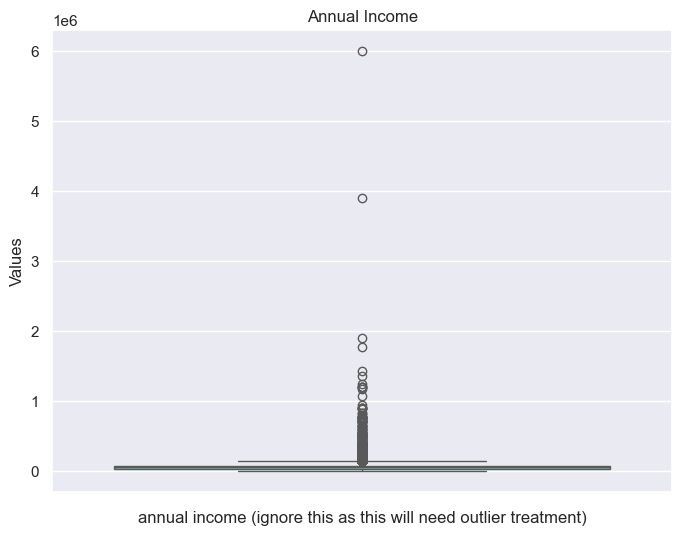

In [32]:
create_boxplot(df.annual_inc, 'annual income (ignore this as this will need outlier treatment)', title='Annual Income')

### Loan Amount

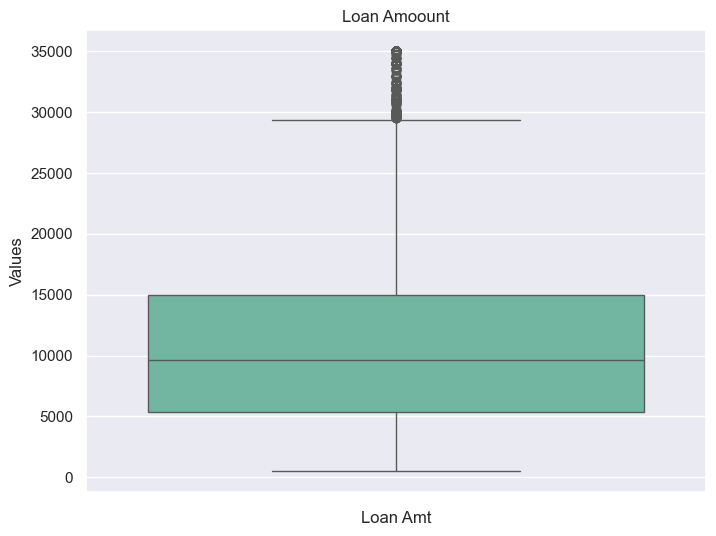

In [33]:
create_boxplot(df.loan_amnt, 'Loan Amt', title='Loan Amoount')

### Funded Amount

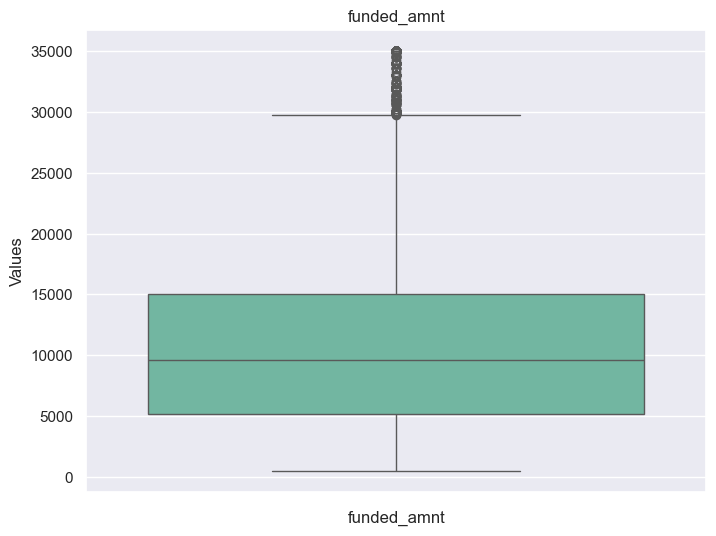

In [34]:
create_boxplot(df.funded_amnt, 'funded_amnt', title='funded_amnt')

### Interest rate

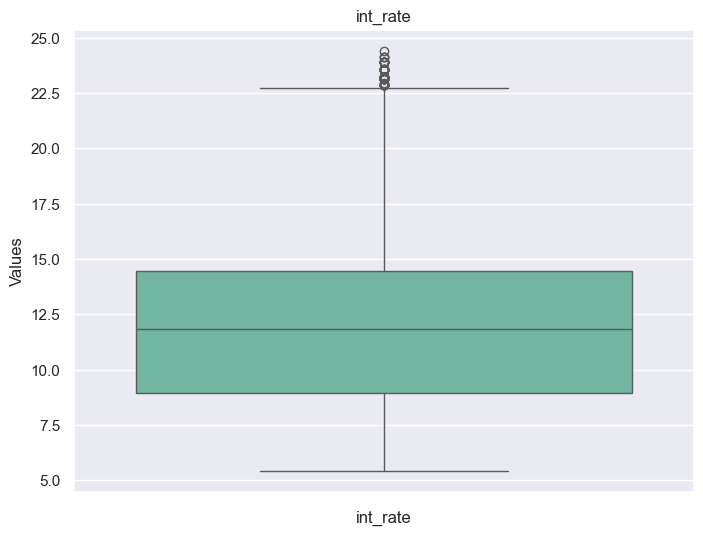

In [35]:
create_boxplot(df.int_rate, 'int_rate', title='int_rate')

In [36]:
int_rate_IQR = get_IQR_stats(df.int_rate)
int_rate_IQR 

{'iqr': 5.520000000000001,
 'quartile_025': 8.94,
 'quartile_075': 14.46,
 'IQR_lb': 0.6599999999999984,
 'IQR_ub': 22.740000000000002}

### DTI

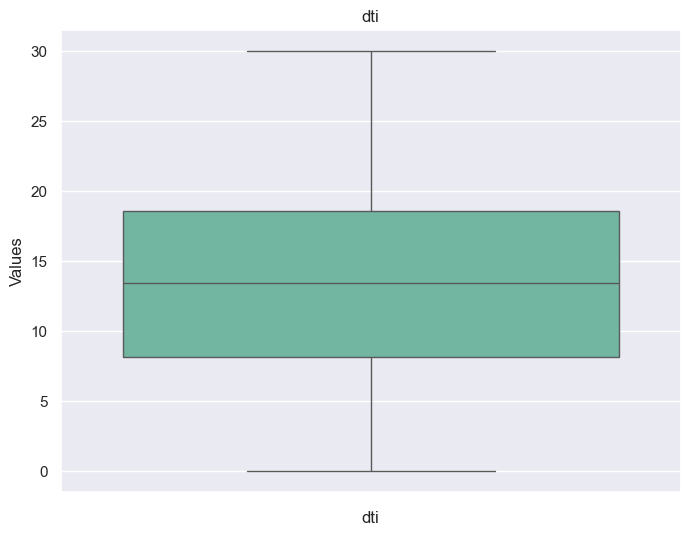

In [37]:
create_boxplot(df.dti, 'dti', title='dti')

### Open Accounts

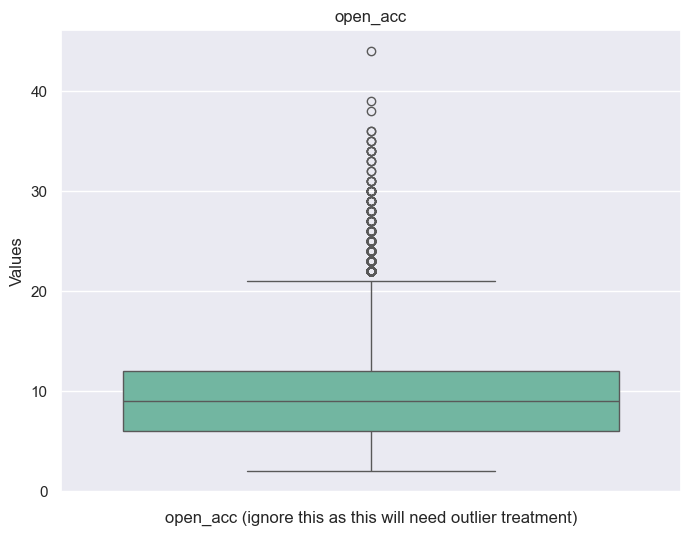

In [38]:
create_boxplot(df.open_acc, 'open_acc (ignore this as this will need outlier treatment)', title='open_acc')

### Installments

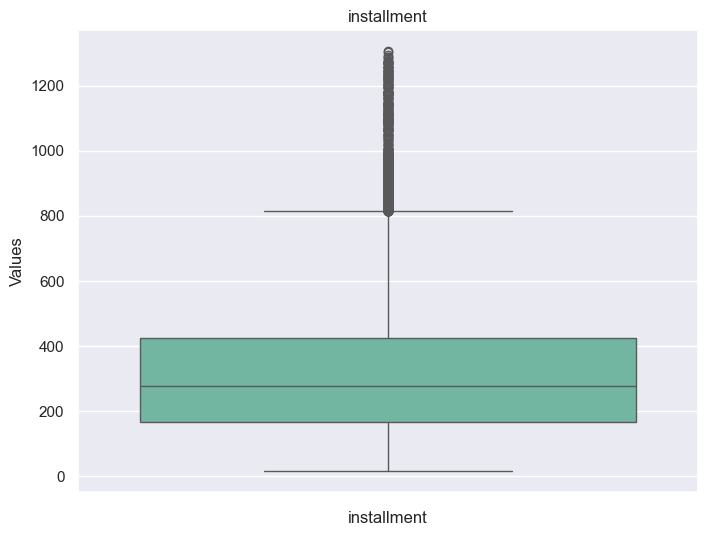

In [39]:
create_boxplot(df.installment, 'installment', title='installment')

## Outliers Treatment

### Annual Income - Outliers Treatment

In [40]:
# Get IQR stats for Annual Income
annual_inc_iqr = get_IQR_stats(df['annual_inc'])
df_annual_inc_iqr = df[(df['annual_inc'] >= annual_inc_iqr.get('IQR_lb')) & (df['annual_inc'] <= annual_inc_iqr.get('IQR_ub'))]

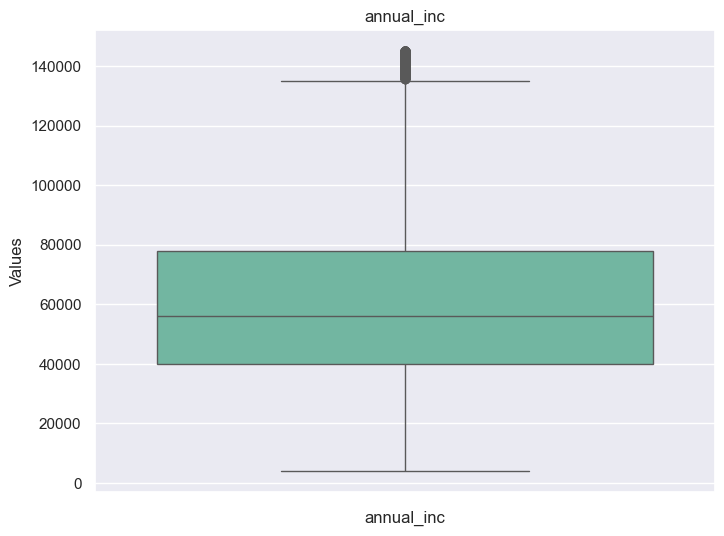

In [41]:
create_boxplot(df_annual_inc_iqr.annual_inc, 'annual_inc', title='annual_inc')

In [42]:
annual_inc_iqr_new = get_IQR_stats(df_annual_inc_iqr.annual_inc)
annual_inc_iqr_new

{'iqr': 38000.0,
 'quartile_025': 40000.0,
 'quartile_075': 78000.0,
 'IQR_lb': -17000.0,
 'IQR_ub': 135000.0}

In [43]:
# Since there are still some outliers pending, check if they can be removed with z score
z_score=np.abs((df_annual_inc_iqr["annual_inc"]-df_annual_inc_iqr["annual_inc"].mean())/df_annual_inc_iqr["annual_inc"].std())
z_score
# None of the values of z_score is beyond 3, hence z_score is not required

0        1.321517
1        1.108829
2        1.737960
3        0.428228
5        0.896142
           ...   
39562    0.931590
39573    0.078678
39623    0.789798
39666    0.754350
39680    0.890718
Name: annual_inc, Length: 36154, dtype: float64

### Open Accounts - Outliers Treatment

In [44]:
# Get IQR stats for open accounts
open_acc_iqr = get_IQR_stats(df.open_acc)
df_open_acc_iqr = df[(df['open_acc'] >= open_acc_iqr.get('IQR_lb')) & (df['open_acc'] <= open_acc_iqr.get('IQR_ub'))]

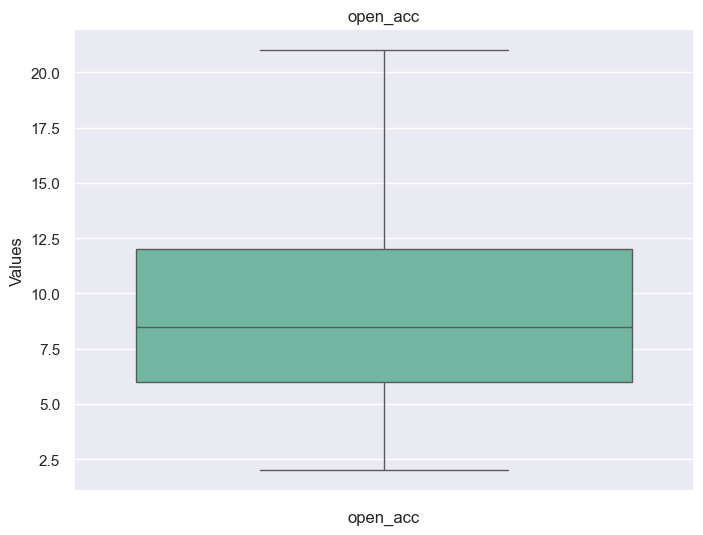

In [45]:
create_boxplot(df_open_acc_iqr.open_acc, 'open_acc', title='open_acc')

In [46]:
open_acc_IQR = get_IQR_stats(df['open_acc'])
open_acc_IQR

{'iqr': 6.0,
 'quartile_025': 6.0,
 'quartile_075': 12.0,
 'IQR_lb': -3.0,
 'IQR_ub': 21.0}

## Understanding Term

In [47]:
df.term.unique()

array([36, 60], dtype=int64)

In [48]:
# Get understanding of term
term_36_perc = round(100 * (len(df[df.term == 36].index)/len(df.index)))
term_36_perc

75

In [49]:
df.shape

(37880, 29)

## Data point Inference

1) Annual Income IQR is 38000.0. 25% to 75% of loan applicants have income between 40K to 78K
2) Loan amount IQR is 10K. 25% to 75% of loan applicants have loan amount between 5K to 15K
3) Funded amount IQR is 10K. 25% to 75% of loan applicants have funded amount between 5K to 15K
4) Interest rate IQR is 5%. 25% to 75% of loan applicants have interest rate between 9% to 14%
5) Debt to Income (DTI) IQR is 19. 25% to 75% of loan applicants have DTI from 8 to 18
6) Monthly installment amount IQR is 280. 25% to 75% of loan applicants have installments from 160 to 440
7) Typically 6 to 12 open credit lines are observed for loan applicants
8) 75% of loan applicants prefer 36 months duration

# Data Analysis

## High level Summary - Fully Paid against Charged off (Defaulted) Accounts

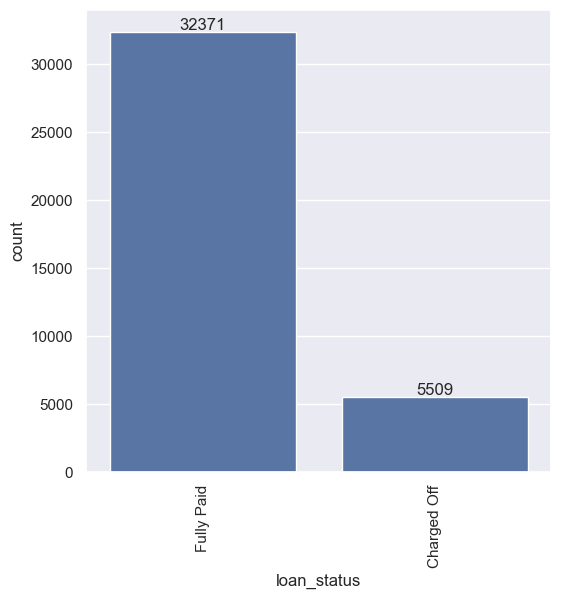

loan_status
Fully Paid     85.5 %
Charged Off    14.5 %
Name: proportion, dtype: object


In [50]:
plot_simple_countplot(df, 'loan_status')

## Defaulted accounts distribution

#### On Verification Status

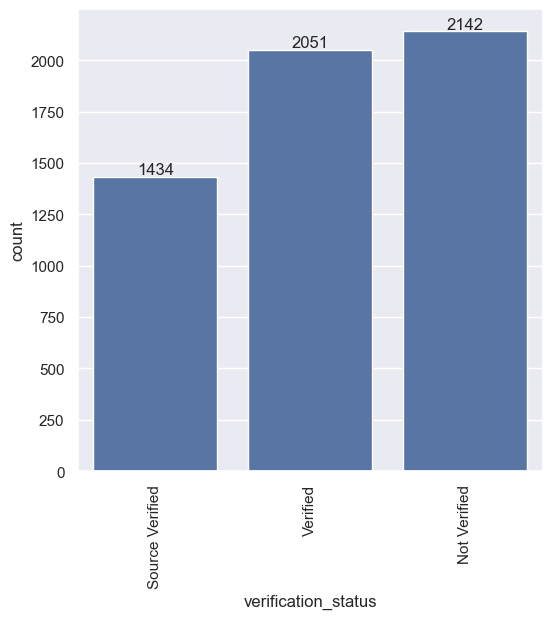

verification_status
Not Verified       38.1 %
Verified           36.4 %
Source Verified    25.5 %
Name: proportion, dtype: object


In [51]:
plot_simple_countplot(df_defaulted, 'verification_status')

Data pointers
1) Defaulters % for Source verified (25%) is lesser than verified and non-verified (74%)
2) Almost 74% of defaulted borrowers are from category verified and non-verified


Inference
1) Probability of Source verified applicants defaulters is less

#### On Open accounts

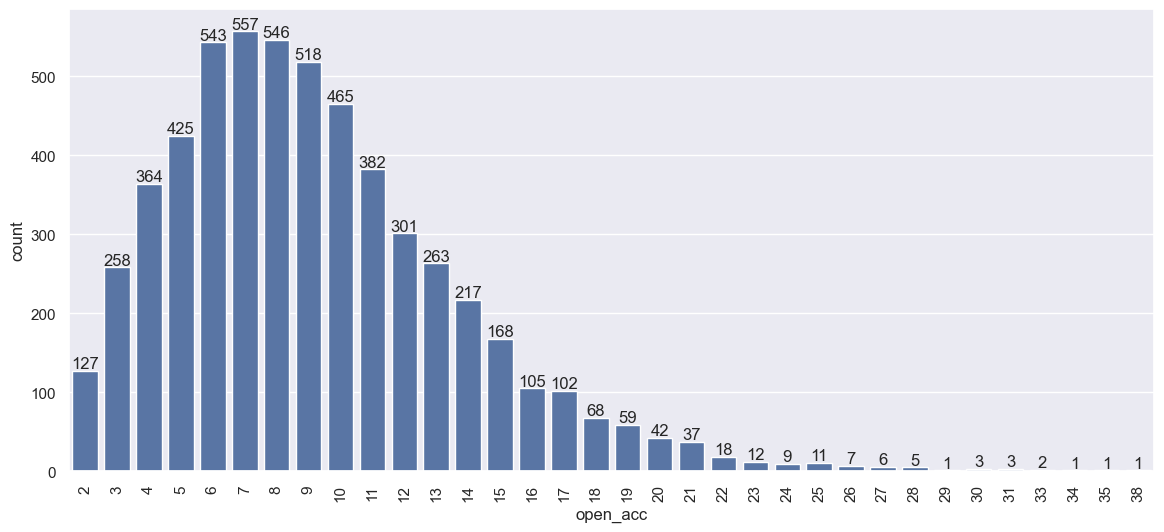

open_acc
7     9.9 %
8     9.7 %
6     9.6 %
9     9.2 %
10    8.3 %
5     7.6 %
11    6.8 %
4     6.5 %
12    5.3 %
13    4.7 %
3     4.6 %
14    3.9 %
15    3.0 %
2     2.3 %
16    1.9 %
17    1.8 %
18    1.2 %
19    1.0 %
20    0.7 %
21    0.7 %
22    0.3 %
23    0.2 %
25    0.2 %
24    0.2 %
26    0.1 %
27    0.1 %
28    0.1 %
30    0.1 %
31    0.1 %
33    0.0 %
35    0.0 %
29    0.0 %
38    0.0 %
34    0.0 %
Name: proportion, dtype: object


In [52]:
plot_simple_countplot(df_defaulted, 'open_acc',figsize=(14, 6))

Data pointers
1) 54% of defaulted accounts have open account between 5 to 10
2) Open accounts less than 5 and more than 15 shows less defaulting tendency

Inference
1) Lesser the open credit lines, lesser would be defaulting 

#### On Adderess state

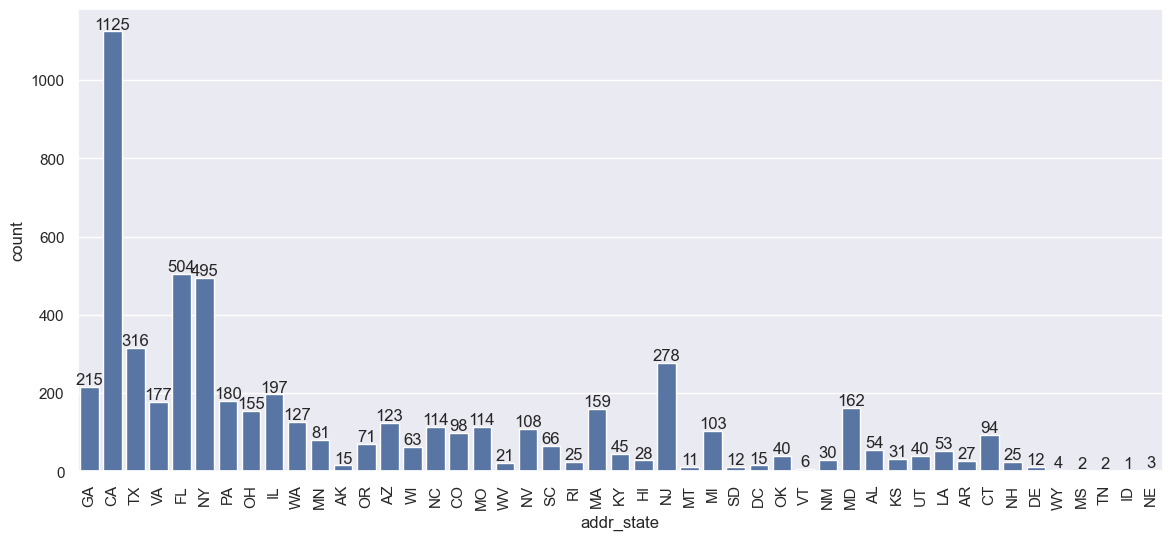

addr_state
CA    20.0 %
FL     9.0 %
NY     8.8 %
TX     5.6 %
NJ     4.9 %
GA     3.8 %
IL     3.5 %
PA     3.2 %
VA     3.1 %
MD     2.9 %
MA     2.8 %
OH     2.8 %
WA     2.3 %
AZ     2.2 %
NC     2.0 %
MO     2.0 %
NV     1.9 %
MI     1.8 %
CO     1.7 %
CT     1.7 %
MN     1.4 %
OR     1.3 %
SC     1.2 %
WI     1.1 %
AL     1.0 %
LA     0.9 %
KY     0.8 %
OK     0.7 %
UT     0.7 %
KS     0.6 %
NM     0.5 %
HI     0.5 %
AR     0.5 %
NH     0.4 %
RI     0.4 %
WV     0.4 %
DC     0.3 %
AK     0.3 %
DE     0.2 %
SD     0.2 %
MT     0.2 %
VT     0.1 %
WY     0.1 %
NE     0.1 %
MS     0.0 %
TN     0.0 %
ID     0.0 %
Name: proportion, dtype: object


In [53]:
plot_simple_countplot(df_defaulted, 'addr_state',figsize=(14, 6))

Data pointers
1) States CA, FL, NY, TX, NJ contributes ~48% of defaulters

#### On Zip code

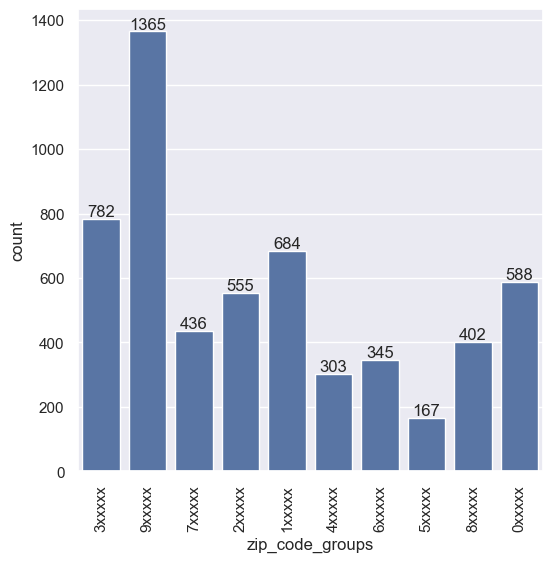

zip_code_groups
9xxxxx    24.3 %
3xxxxx    13.9 %
1xxxxx    12.2 %
0xxxxx    10.4 %
2xxxxx     9.9 %
7xxxxx     7.7 %
8xxxxx     7.1 %
6xxxxx     6.1 %
4xxxxx     5.4 %
5xxxxx     3.0 %
Name: proportion, dtype: object


In [54]:
plot_simple_countplot(df_defaulted, 'zip_code_groups')

Data pointers
1) Zip Code starts 9xxxxx, 3xxxxx, 1xxxxx contributes ~50% of defaulters

#### On annual income

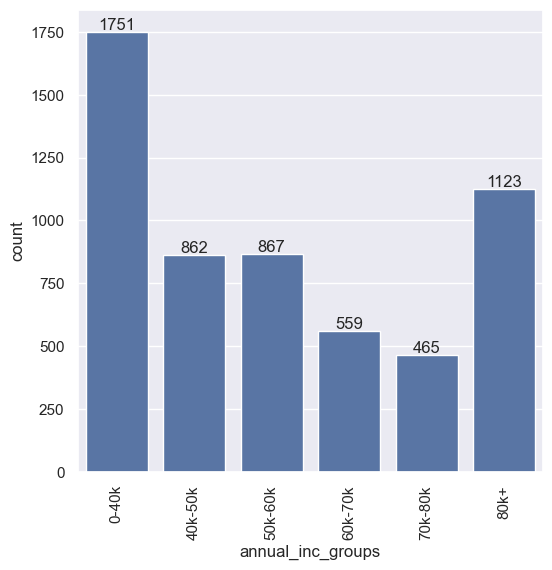

annual_inc_groups
0-40k      31.1 %
80k+       20.0 %
50k-60k    15.4 %
40k-50k    15.3 %
60k-70k     9.9 %
70k-80k     8.3 %
Name: proportion, dtype: object


In [55]:
plot_simple_countplot(df_defaulted, 'annual_inc_groups')

Data pointers
1) ~62% of defaulted loan applicants had income till 60K

#### On DTI

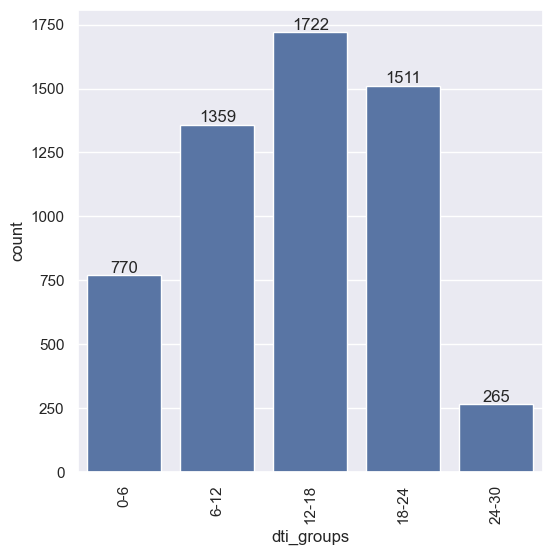

dti_groups
12-18    30.6 %
18-24    26.9 %
6-12     24.2 %
0-6      13.7 %
24-30     4.7 %
Name: proportion, dtype: object


In [56]:
plot_simple_countplot(df_defaulted, 'dti_groups')

Data pointers
1) ~38% of defaulted loan applicants had DTI with 12%

#### On loan amount

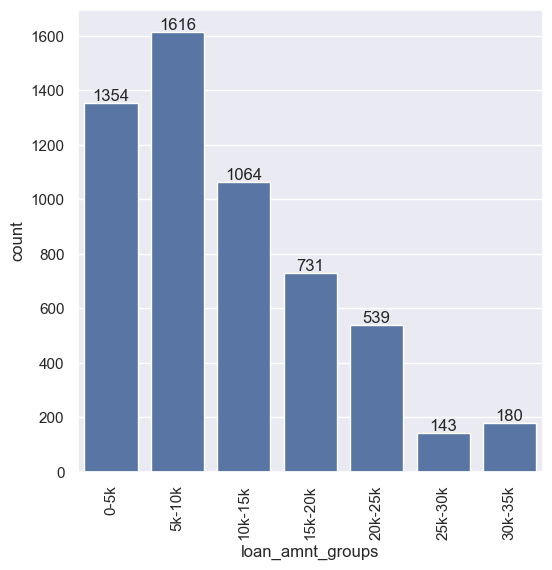

loan_amnt_groups
5k-10k     28.7 %
0-5k       24.1 %
10k-15k    18.9 %
15k-20k    13.0 %
20k-25k     9.6 %
30k-35k     3.2 %
25k-30k     2.5 %
Name: proportion, dtype: object


In [57]:
plot_simple_countplot(df_defaulted, 'loan_amnt_groups')

Data pointers
1) ~72% of defaulted borrowers have loan amount till 15K

#### On Interest rate

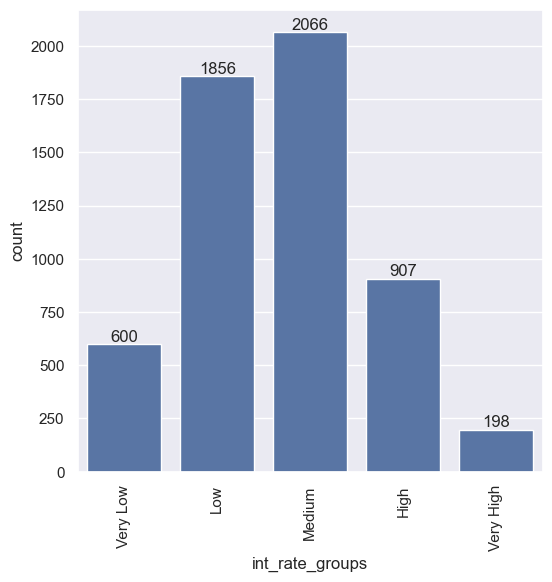

int_rate_groups
Medium       36.7 %
Low          33.0 %
High         16.1 %
Very Low     10.7 %
Very High     3.5 %
Name: proportion, dtype: object


In [58]:
plot_simple_countplot(df_defaulted, 'int_rate_groups')

Data pointers
1) 67% defaulted loan applicants had interest rate between Low and Medium

#### On Purpose (i.e., utilization of borrowed amount)

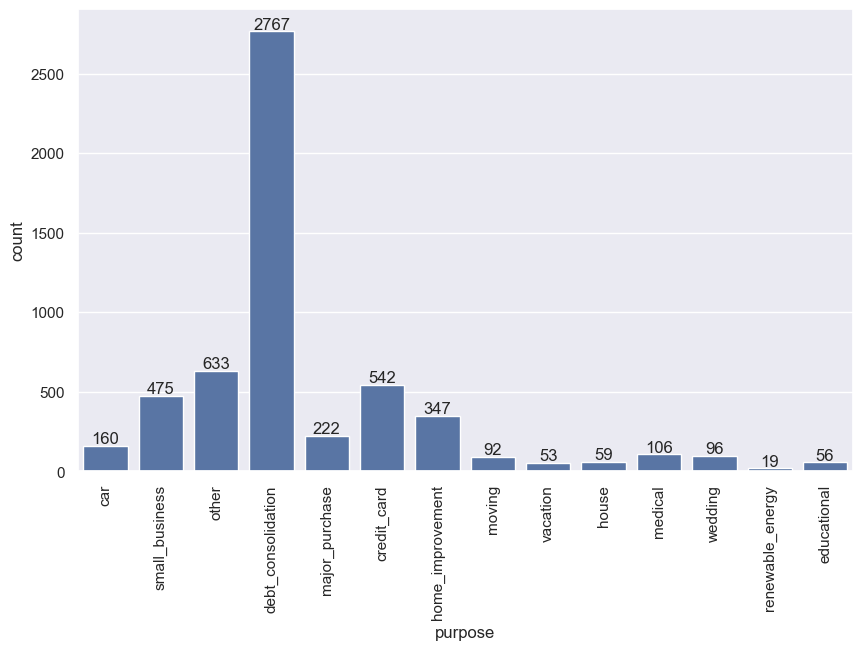

purpose
debt_consolidation    49.2 %
other                 11.2 %
credit_card            9.6 %
small_business         8.4 %
home_improvement       6.2 %
major_purchase         3.9 %
car                    2.8 %
medical                1.9 %
wedding                1.7 %
moving                 1.6 %
house                  1.0 %
educational            1.0 %
vacation               0.9 %
renewable_energy       0.3 %
Name: proportion, dtype: object


In [59]:
plot_simple_countplot(df_defaulted, 'purpose',figsize=(10, 6))

Data pointers
1) 59% of defaulted loan applicants borrowed to debt_consolidation and for credit cards bills

#### On Term

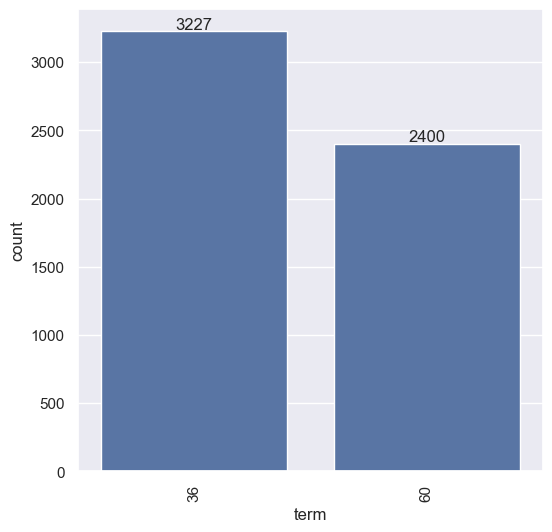

term
36    57.3 %
60    42.7 %
Name: proportion, dtype: object


In [60]:
plot_simple_countplot(df_defaulted, 'term')

Data pointers
1) 57% of loan applicants having 36 months term are defaulting

#### On Employee length

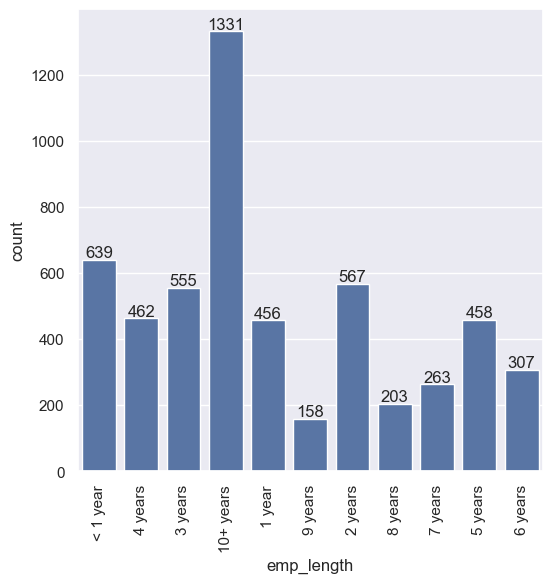

emp_length
10+ years    24.7 %
< 1 year     11.8 %
2 years      10.5 %
3 years      10.3 %
4 years       8.6 %
5 years       8.5 %
1 year        8.4 %
6 years       5.7 %
7 years       4.9 %
8 years       3.8 %
9 years       2.9 %
Name: proportion, dtype: object


In [61]:
plot_simple_countplot(df_defaulted, 'emp_length')

Data pointers
1) 36% of defaulters have working experience more than 7 years

#### On Grade

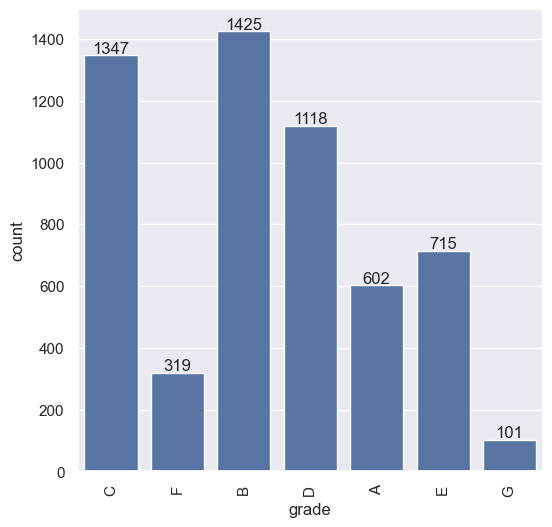

grade
B    25.3 %
C    23.9 %
D    19.9 %
E    12.7 %
A    10.7 %
F     5.7 %
G     1.8 %
Name: proportion, dtype: object


In [62]:
plot_simple_countplot(df_defaulted, 'grade')

Data pointers
1) 69% of defaulted accounts are from B, C and D grade

#### On Home Ownership

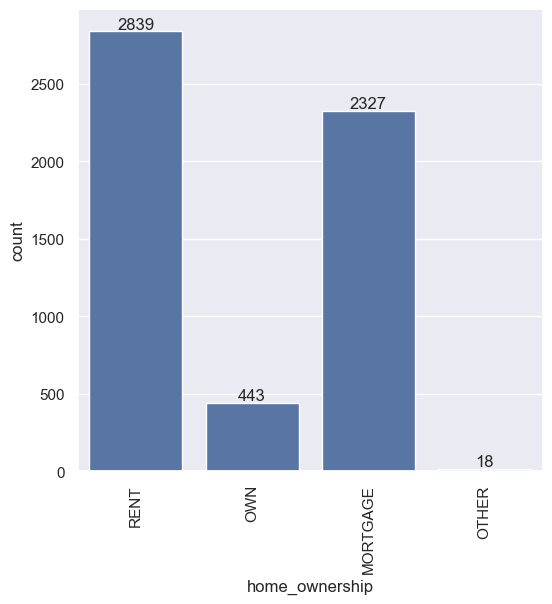

home_ownership
RENT        50.5 %
MORTGAGE    41.4 %
OWN          7.9 %
OTHER        0.3 %
Name: proportion, dtype: object


In [63]:
plot_simple_countplot(df_defaulted, 'home_ownership')

Data pointers
1) 50% of defaulters does not own house.

#### On Employee title (Note - Employer Title replaces Employer Name for all loans listed after 9/23/2013)

In [64]:
default_counts = df_defaulted['emp_title'].value_counts().reset_index() 
default_counts.columns = ['emp_title', 'Default_Count']
top_15_defaults = default_counts.nlargest(15, 'Default_Count')
top_15_defaults.Default_Count.sum()

146

In [65]:
top_15_defaults

,emp_title,Default_Count
0,Bank of America,20
1,US Army,18
2,Walmart,14
3,UPS,12
4,AT&T,12
5,IBM,9
6,Kaiser Permanente,8
7,U.S. Army,8
8,Target,7
9,USPS,7


Data pointers
1) Top 15 employers contributes 146 defaulters out of 5509 defaulters. Nothing conclusive on employer title

## Fully Paid accounts distribution

#### On Verification Status

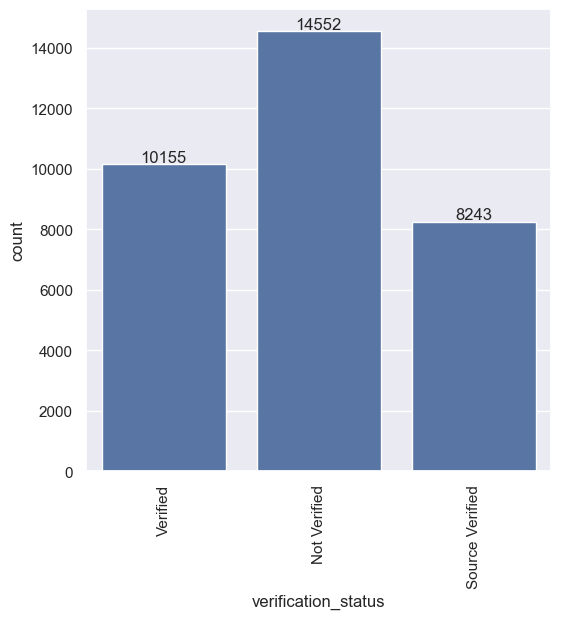

verification_status
Not Verified       44.2 %
Verified           30.8 %
Source Verified    25.0 %
Name: proportion, dtype: object


In [66]:
plot_simple_countplot(df_fully_paid, 'verification_status')

Data pointers

1) 56% of fully paid borrowers are verified  

#### On Adderess state

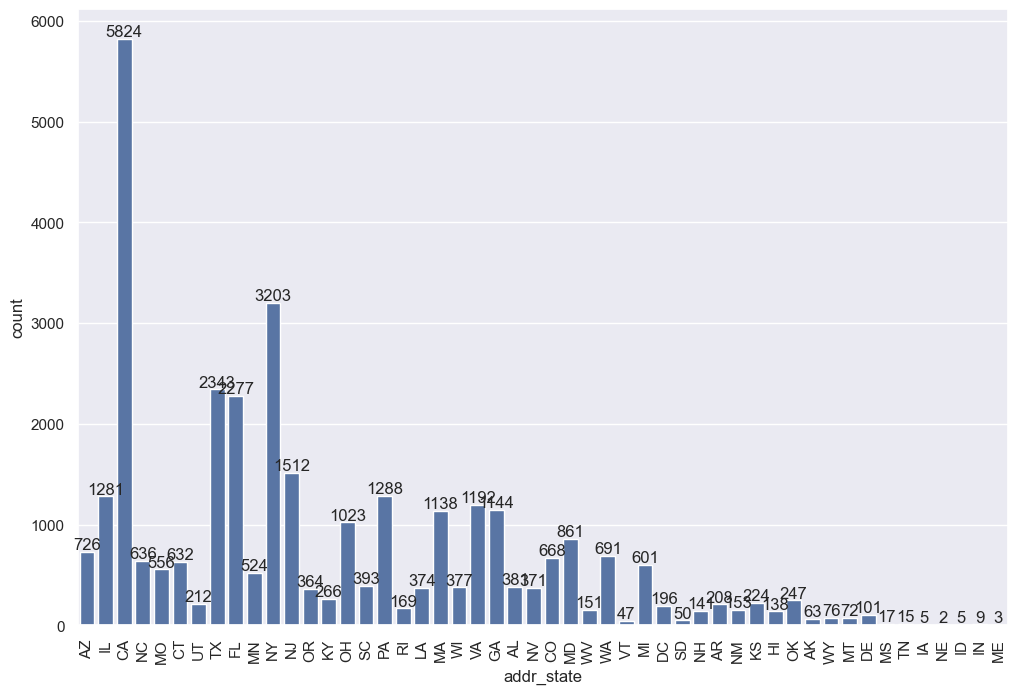

addr_state
CA    17.7 %
NY     9.7 %
TX     7.1 %
FL     6.9 %
NJ     4.6 %
PA     3.9 %
IL     3.9 %
VA     3.6 %
GA     3.5 %
MA     3.5 %
OH     3.1 %
MD     2.6 %
AZ     2.2 %
WA     2.1 %
CO     2.0 %
NC     1.9 %
CT     1.9 %
MI     1.8 %
MO     1.7 %
MN     1.6 %
SC     1.2 %
AL     1.2 %
WI     1.1 %
LA     1.1 %
NV     1.1 %
OR     1.1 %
KY     0.8 %
OK     0.7 %
KS     0.7 %
UT     0.6 %
AR     0.6 %
DC     0.6 %
RI     0.5 %
NM     0.5 %
WV     0.5 %
NH     0.4 %
HI     0.4 %
DE     0.3 %
WY     0.2 %
MT     0.2 %
AK     0.2 %
SD     0.2 %
VT     0.1 %
MS     0.1 %
TN     0.0 %
IN     0.0 %
IA     0.0 %
ID     0.0 %
ME     0.0 %
NE     0.0 %
Name: proportion, dtype: object


In [67]:
plot_simple_countplot(df_fully_paid, 'addr_state',figsize=(12, 8))

Data pointers

1) 46% of fully paid borrowers are from states CA, FL, NY, TX, NJ

#### On Zip code

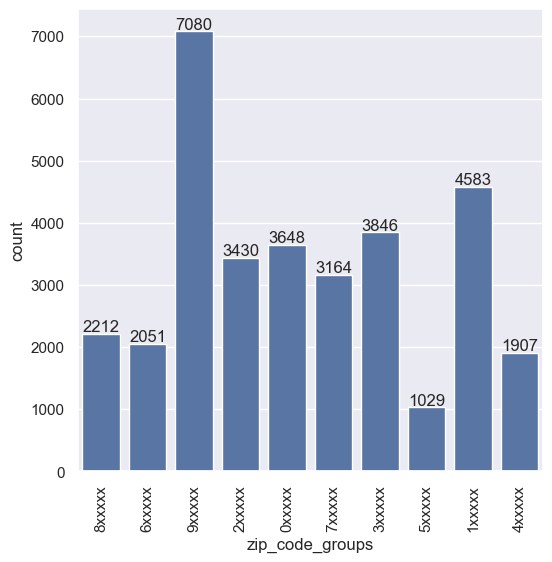

zip_code_groups
9xxxxx    21.5 %
1xxxxx    13.9 %
3xxxxx    11.7 %
0xxxxx    11.1 %
2xxxxx    10.4 %
7xxxxx     9.6 %
8xxxxx     6.7 %
6xxxxx     6.2 %
4xxxxx     5.8 %
5xxxxx     3.1 %
Name: proportion, dtype: object


In [68]:
plot_simple_countplot(df_fully_paid, 'zip_code_groups')

Data pointers
1) 47% of fully paid borrowers are from Zip Code starts with 9xxxxx, 3xxxxx, 1xxxxx

#### On Employee Length

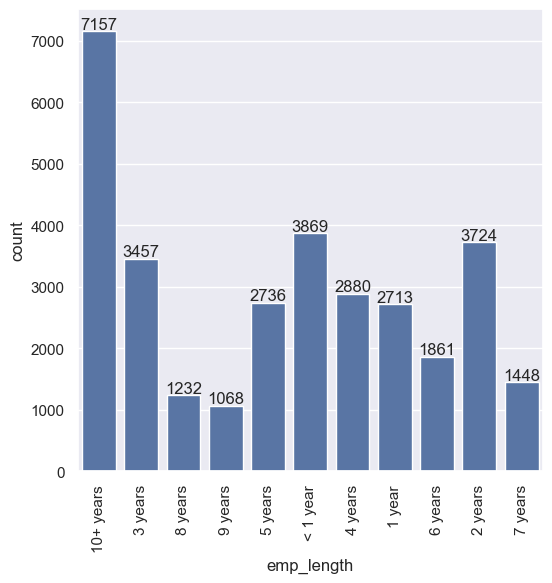

emp_length
10+ years    22.3 %
< 1 year     12.0 %
2 years      11.6 %
3 years      10.8 %
4 years       9.0 %
5 years       8.5 %
1 year        8.4 %
6 years       5.8 %
7 years       4.5 %
8 years       3.8 %
9 years       3.3 %
Name: proportion, dtype: object


In [69]:
plot_simple_countplot(df_fully_paid, 'emp_length')

Data pointers
1) 34% of fully paid borrowers are having working experience more than 7 years

#### On Purpose

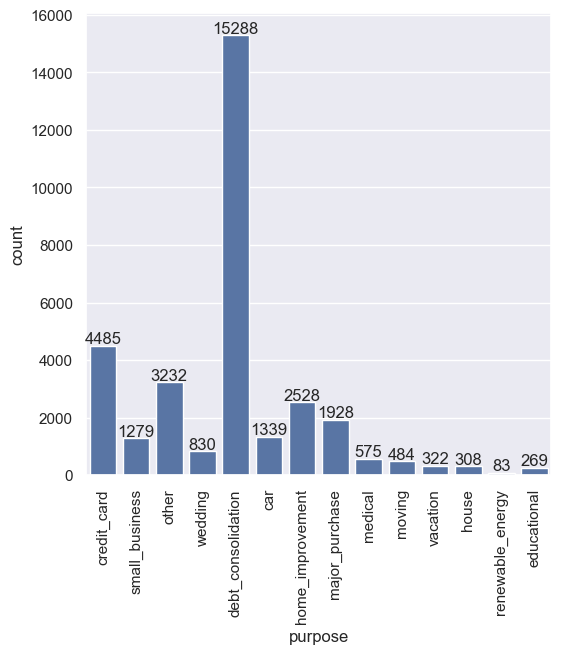

purpose
debt_consolidation    46.4 %
credit_card           13.6 %
other                  9.8 %
home_improvement       7.7 %
major_purchase         5.9 %
car                    4.1 %
small_business         3.9 %
wedding                2.5 %
medical                1.7 %
moving                 1.5 %
vacation               1.0 %
house                  0.9 %
educational            0.8 %
renewable_energy       0.3 %
Name: proportion, dtype: object


In [70]:
plot_simple_countplot(df_fully_paid, 'purpose')

Data pointers
1) 60% of fully paid borrowers, borrowed for the purpose for debt_consolidation and for credit cards bills

#### On Open accounts

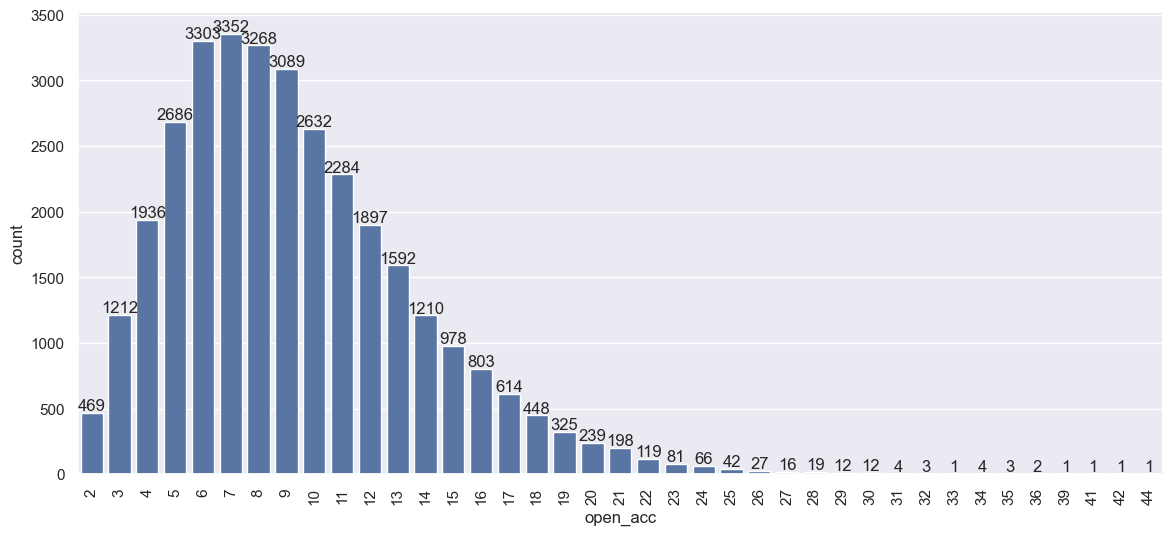

open_acc
7     10.2 %
6     10.0 %
8      9.9 %
9      9.4 %
5      8.2 %
10     8.0 %
11     6.9 %
4      5.9 %
12     5.8 %
13     4.8 %
3      3.7 %
14     3.7 %
15     3.0 %
16     2.4 %
17     1.9 %
2      1.4 %
18     1.4 %
19     1.0 %
20     0.7 %
21     0.6 %
22     0.4 %
23     0.2 %
24     0.2 %
25     0.1 %
26     0.1 %
28     0.1 %
27     0.0 %
30     0.0 %
29     0.0 %
31     0.0 %
34     0.0 %
32     0.0 %
35     0.0 %
36     0.0 %
39     0.0 %
33     0.0 %
44     0.0 %
41     0.0 %
42     0.0 %
Name: proportion, dtype: object


In [71]:
plot_simple_countplot(df_fully_paid, 'open_acc',figsize=(14, 6))

Data pointers
1) 56% of fully paid borrowers had open account between 5 to 10

## Univariate Analysis

### Ordered Categorical variables

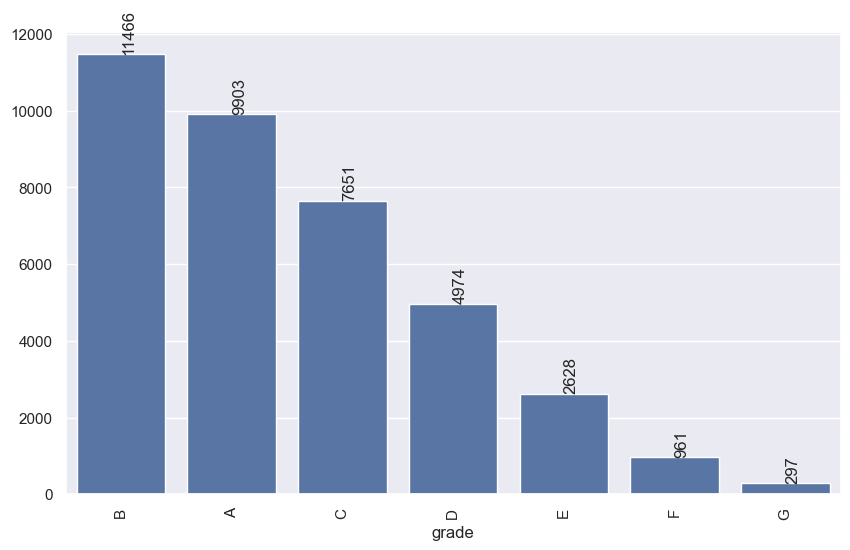

B : 30.3 %
A : 26.1 %
C : 20.2 %
D : 13.1 %
E : 6.9 %
F : 2.5 %
G : 0.8 %


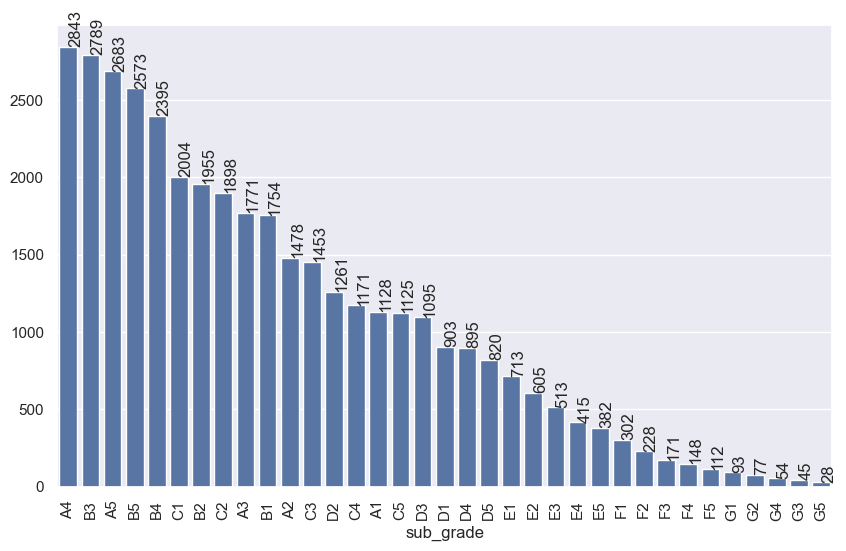

A4 : 7.5 %
B3 : 7.4 %
A5 : 7.1 %
B5 : 6.8 %
B4 : 6.3 %
C1 : 5.3 %
B2 : 5.2 %
C2 : 5.0 %
A3 : 4.7 %
B1 : 4.6 %
A2 : 3.9 %
C3 : 3.8 %
D2 : 3.3 %
C4 : 3.1 %
A1 : 3.0 %
C5 : 3.0 %
D3 : 2.9 %
D1 : 2.4 %
D4 : 2.4 %
D5 : 2.2 %
E1 : 1.9 %
E2 : 1.6 %
E3 : 1.4 %
E4 : 1.1 %
E5 : 1.0 %
F1 : 0.8 %
F2 : 0.6 %
F3 : 0.5 %
F4 : 0.4 %
F5 : 0.3 %
G1 : 0.2 %
G2 : 0.2 %
G4 : 0.1 %
G3 : 0.1 %
G5 : 0.1 %


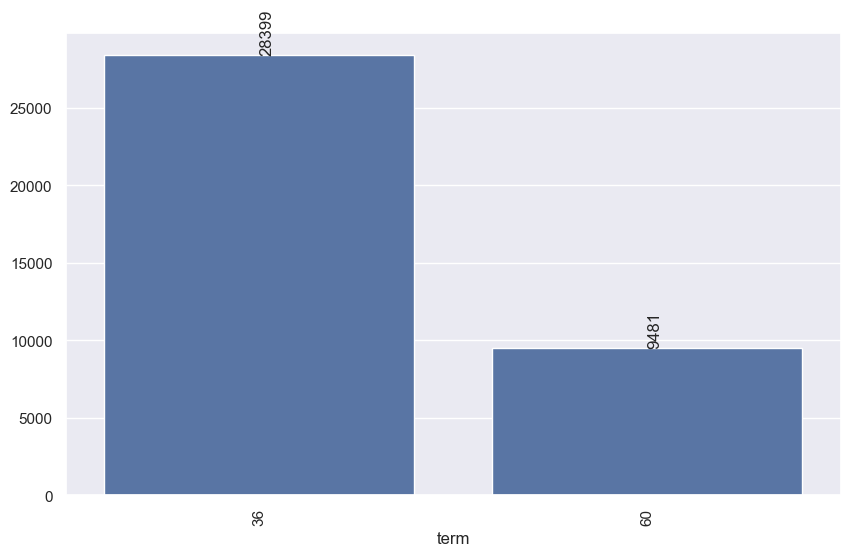

36 : 75.0 %
60 : 25.0 %


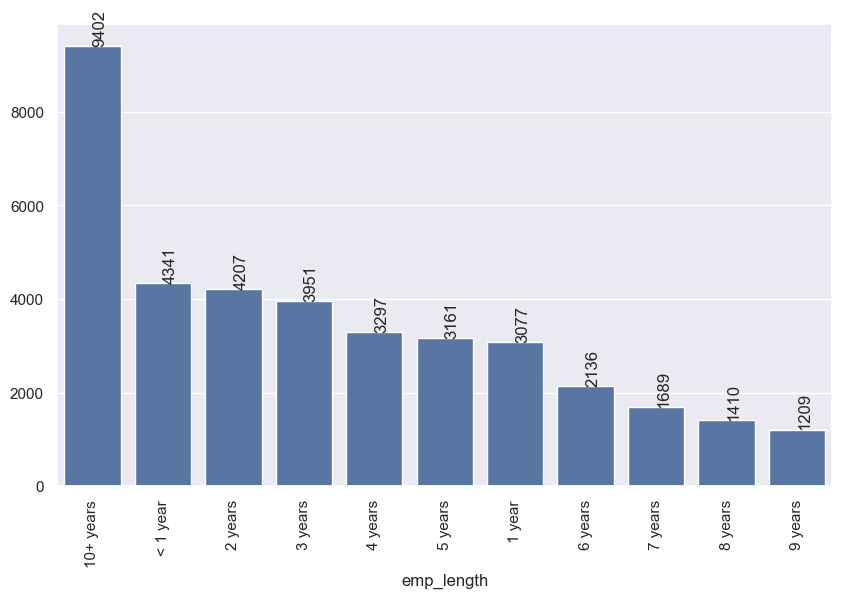

10+ years : 24.8 %
< 1 year : 11.5 %
2 years : 11.1 %
3 years : 10.4 %
4 years : 8.7 %
5 years : 8.3 %
1 year : 8.1 %
6 years : 5.6 %
7 years : 4.5 %
8 years : 3.7 %
9 years : 3.2 %


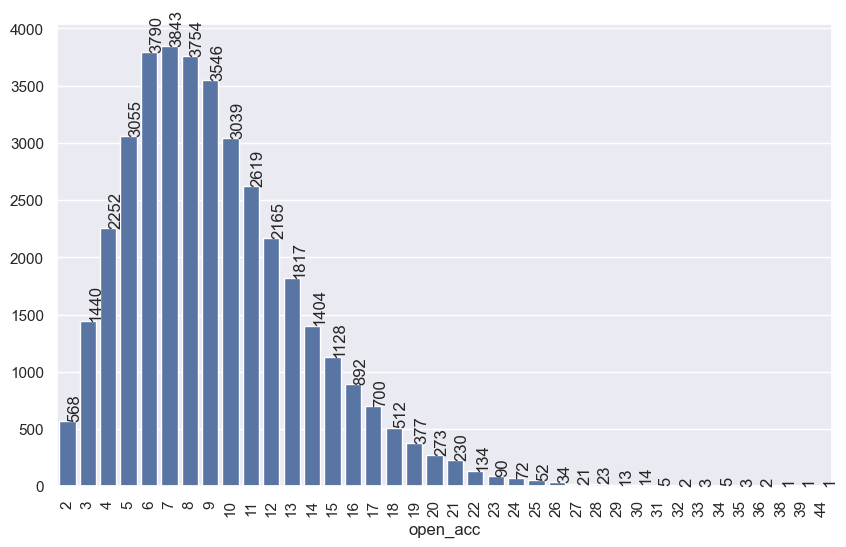

7 : 10.1 %
6 : 10.0 %
8 : 9.9 %
9 : 9.4 %
5 : 8.1 %
10 : 8.0 %
11 : 6.9 %
4 : 5.9 %
12 : 5.7 %
13 : 4.8 %
3 : 3.8 %
14 : 3.7 %
15 : 3.0 %
16 : 2.4 %
17 : 1.8 %
2 : 1.5 %
18 : 1.4 %
19 : 1.0 %
20 : 0.7 %
21 : 0.6 %
22 : 0.4 %
23 : 0.2 %
24 : 0.2 %
25 : 0.1 %
26 : 0.1 %
28 : 0.1 %
27 : 0.1 %
30 : 0.0 %
29 : 0.0 %
34 : 0.0 %
31 : 0.0 %
33 : 0.0 %
35 : 0.0 %
32 : 0.0 %
36 : 0.0 %
39 : 0.0 %
38 : 0.0 %
44 : 0.0 %


In [72]:
for item in ['grade', 'sub_grade', 'term', 'emp_length','open_acc']:
    plot_bar_graph(df[item])

1) Around 77% of accounts are from B, C and D grades. Out of which, B grade contributes the most of the loan accounts i.e., 30%
2) short term loans whose tenure is 36 months were highest in all loan accounts. 
3) Applicants who are employed for 10+ years appear to be contributing to highest loan accounts.
4) 54% of loan accounts have open account between 5 to 10

### Un-Ordered Categorical variables

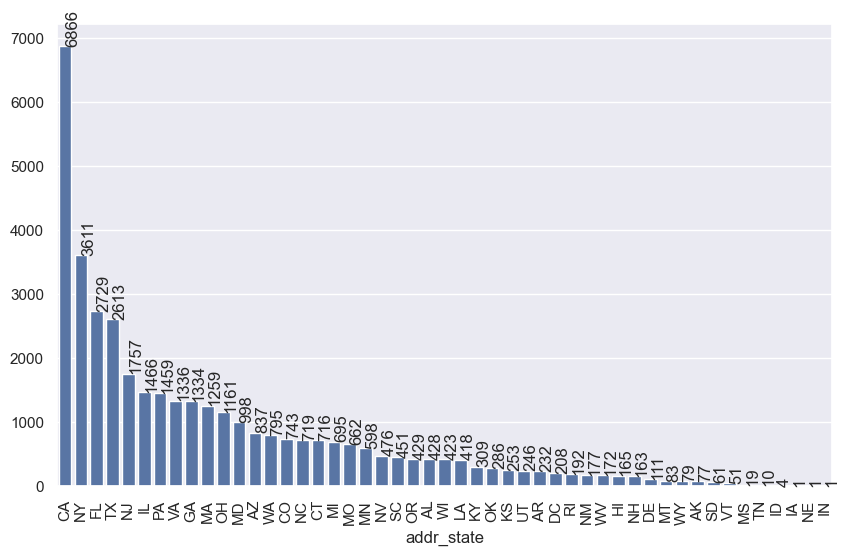

CA : 18.1 %
NY : 9.5 %
FL : 7.2 %
TX : 6.9 %
NJ : 4.6 %
IL : 3.9 %
PA : 3.9 %
VA : 3.5 %
GA : 3.5 %
MA : 3.3 %
OH : 3.1 %
MD : 2.6 %
AZ : 2.2 %
WA : 2.1 %
CO : 2.0 %
NC : 1.9 %
CT : 1.9 %
MI : 1.8 %
MO : 1.7 %
MN : 1.6 %
NV : 1.3 %
SC : 1.2 %
OR : 1.1 %
AL : 1.1 %
WI : 1.1 %
LA : 1.1 %
KY : 0.8 %
OK : 0.8 %
KS : 0.7 %
UT : 0.6 %
AR : 0.6 %
DC : 0.5 %
RI : 0.5 %
NM : 0.5 %
WV : 0.5 %
HI : 0.4 %
NH : 0.4 %
DE : 0.3 %
MT : 0.2 %
WY : 0.2 %
AK : 0.2 %
SD : 0.2 %
VT : 0.1 %
MS : 0.1 %
TN : 0.0 %
ID : 0.0 %
IA : 0.0 %
NE : 0.0 %
IN : 0.0 %


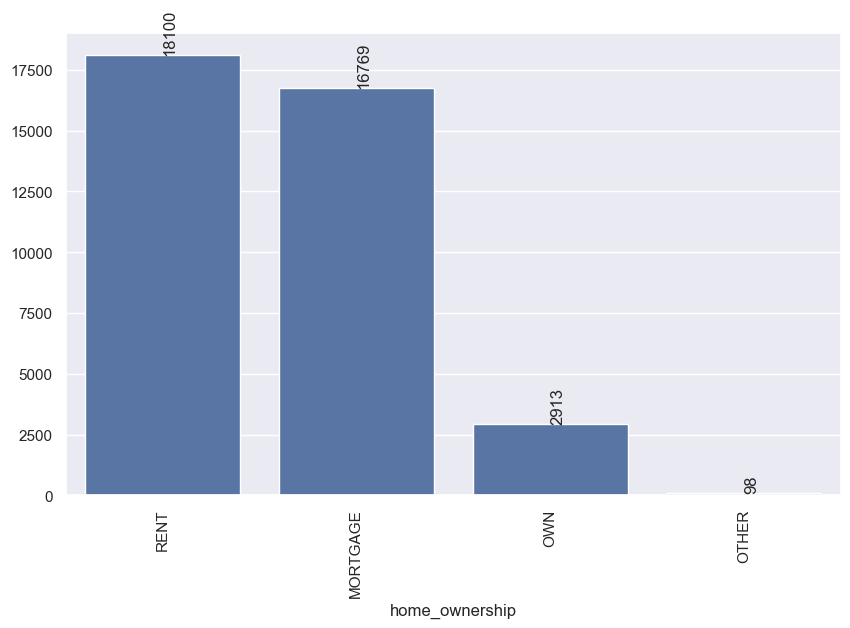

RENT : 47.8 %
MORTGAGE : 44.3 %
OWN : 7.7 %
OTHER : 0.3 %


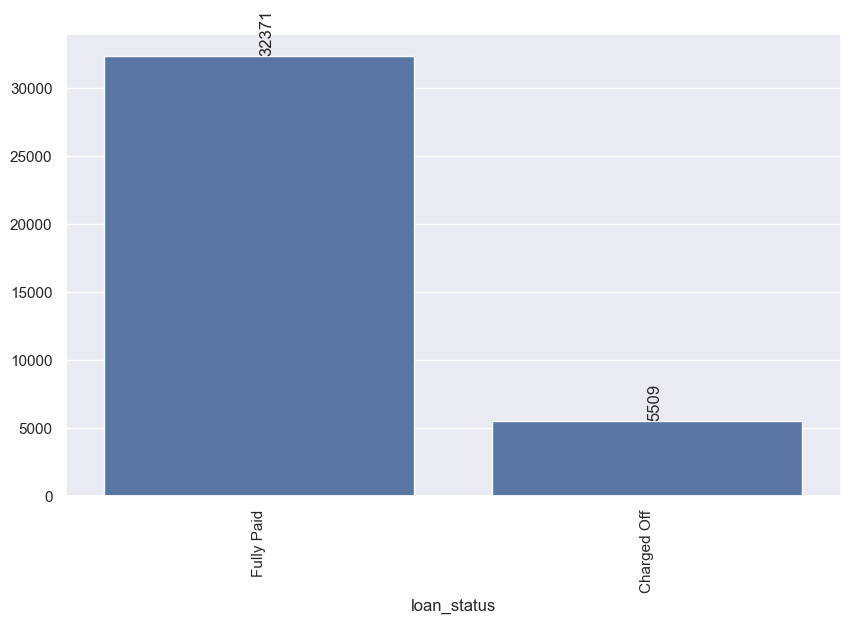

Fully Paid : 85.5 %
Charged Off : 14.5 %


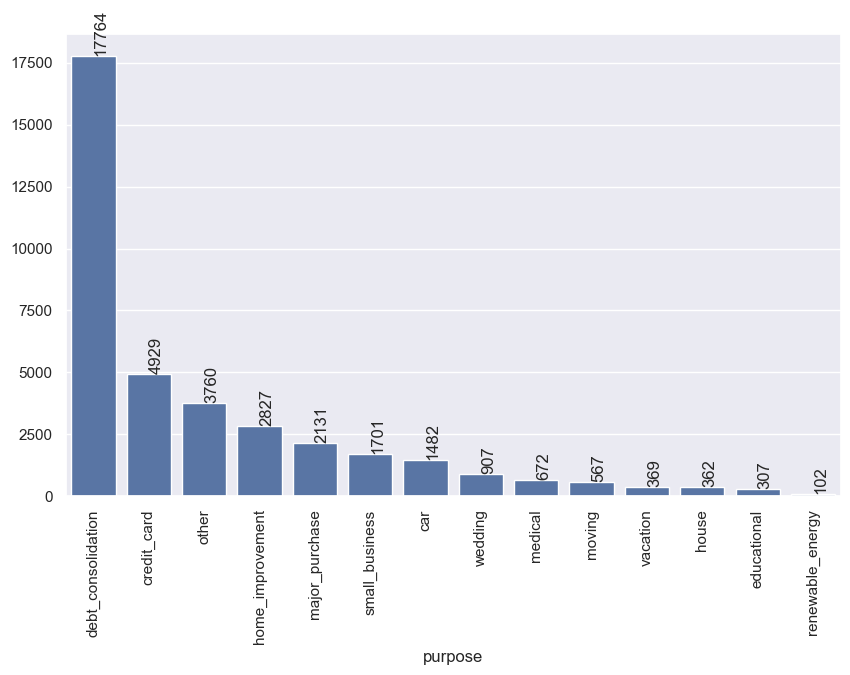

debt_consolidation : 46.9 %
credit_card : 13.0 %
other : 9.9 %
home_improvement : 7.5 %
major_purchase : 5.6 %
small_business : 4.5 %
car : 3.9 %
wedding : 2.4 %
medical : 1.8 %
moving : 1.5 %
vacation : 1.0 %
house : 1.0 %
educational : 0.8 %
renewable_energy : 0.3 %


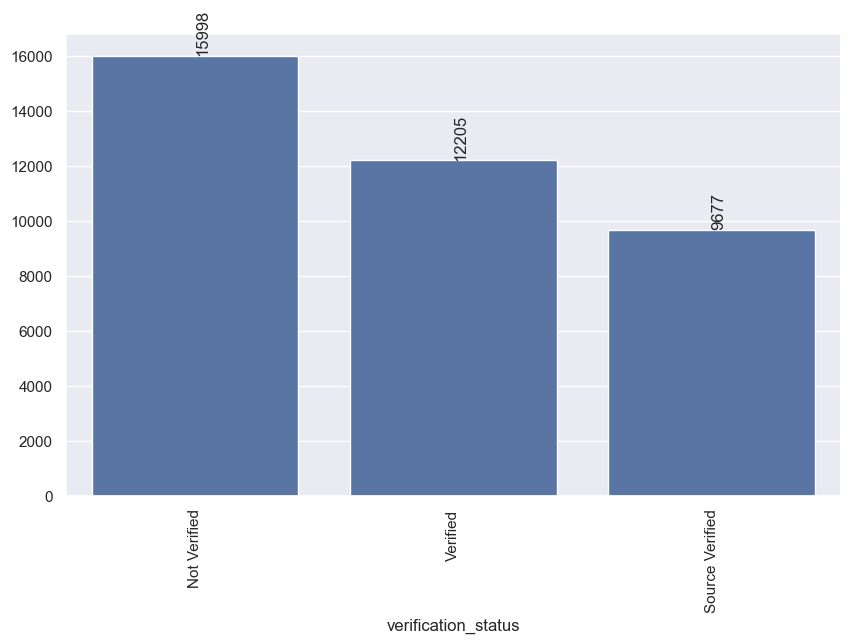

Not Verified : 42.2 %
Verified : 32.2 %
Source Verified : 25.5 %


In [73]:
for item in ['addr_state','home_ownership', 'loan_status', 'purpose', 'verification_status']:
    plot_bar_graph(df[item])

1) California has the highest number applicants which is contributing 18.1% to total percent. And also California has highest number of charged off applicants 
as well. Hence the lending/finance company has to implement stricter rules for eligibility criteria due the higher defaulters  
2) Most of the applicants live in rented house contributing to 47.8%. And also the highest defaulters are from rented house category.
The company must assess the financial status of rented applicants as they are more suspectable to be defaulters.
3) A significant number of applicants are loan defaulters which is around 14%. The lending company has to assess more on the reasons why applicants are
unable to repay the loan. They have to concentrate more on risk factor assessments etc., 
4) Majority of the applicants are who had applied the loan for debt_consolidation which is contributing to 47% of the total percent. The lending company has
to take strict measures while approving loan for the purpose of debt consolidation as we could observe defaulters are also high under the debt consolidation.
5) Applicants who are not verified contribute to 42.2 percent to the total of verification status. It is always recommended to verify the applicants before
processing the loan.

### Segmented univariate analysis

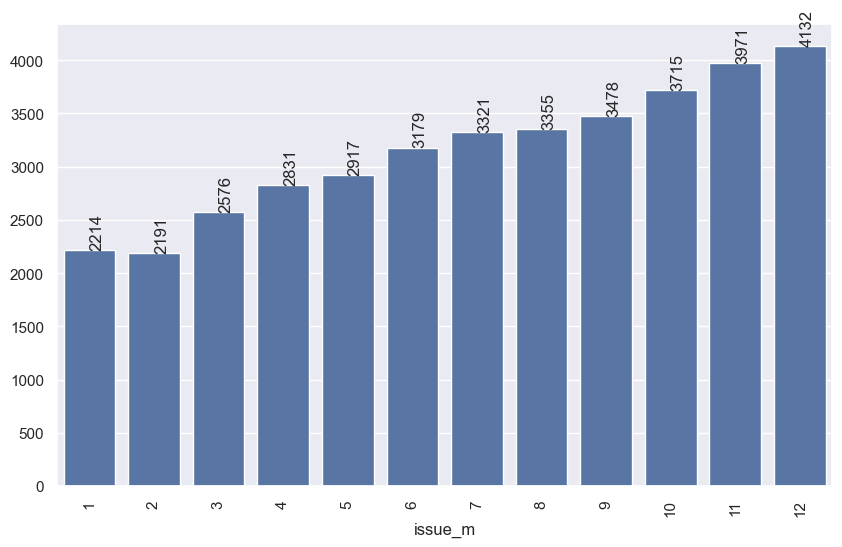

12 : 10.9 %
11 : 10.5 %
10 : 9.8 %
9 : 9.2 %
8 : 8.9 %
7 : 8.8 %
6 : 8.4 %
5 : 7.7 %
4 : 7.5 %
3 : 6.8 %
1 : 5.8 %
2 : 5.8 %


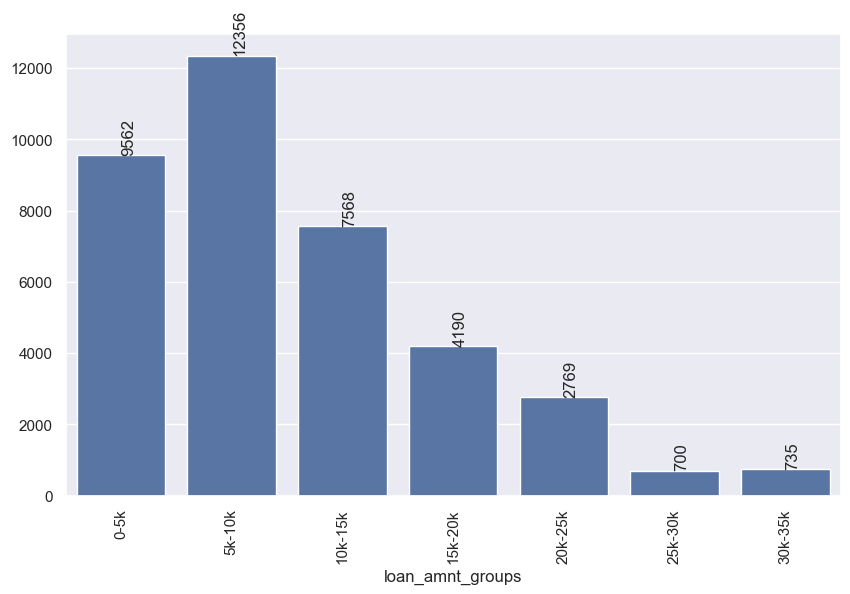

5k-10k : 32.6 %
0-5k : 25.2 %
10k-15k : 20.0 %
15k-20k : 11.1 %
20k-25k : 7.3 %
30k-35k : 1.9 %
25k-30k : 1.8 %


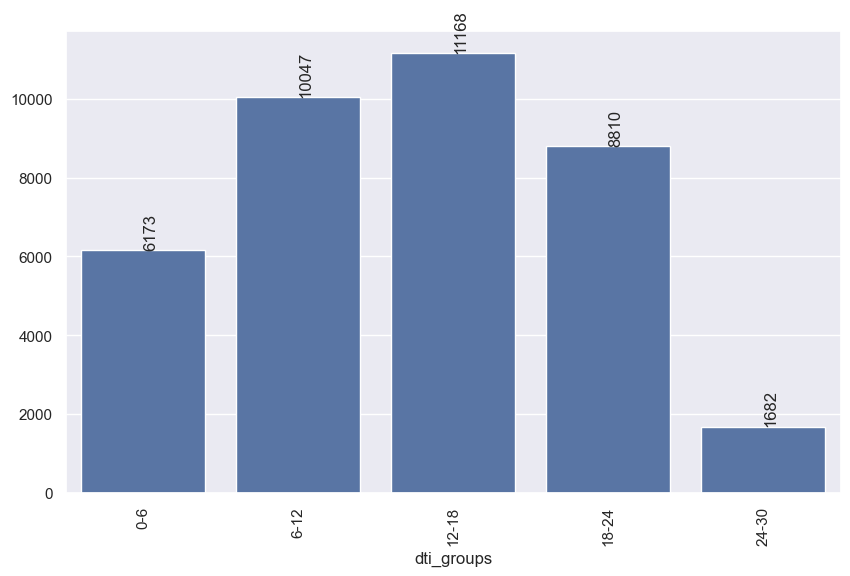

12-18 : 29.5 %
6-12 : 26.5 %
18-24 : 23.3 %
0-6 : 16.3 %
24-30 : 4.4 %


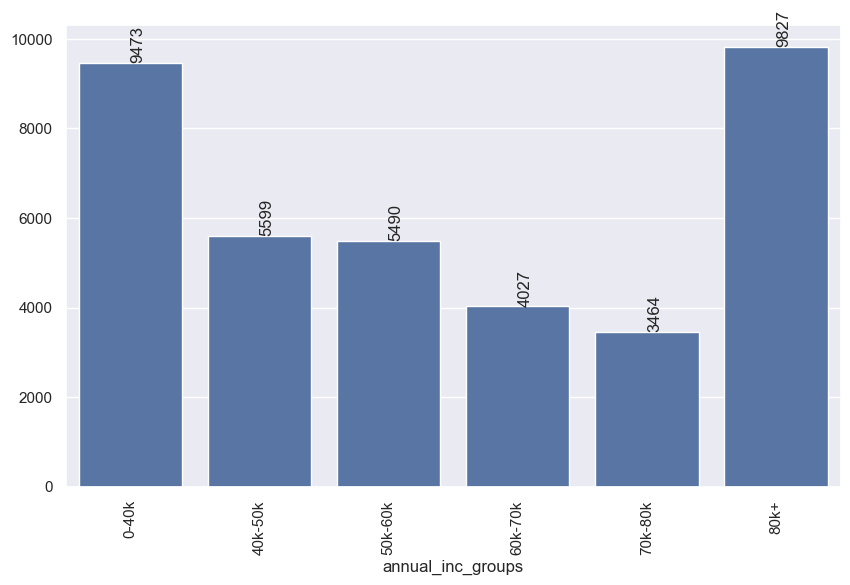

80k+ : 25.9 %
0-40k : 25.0 %
40k-50k : 14.8 %
50k-60k : 14.5 %
60k-70k : 10.6 %
70k-80k : 9.1 %


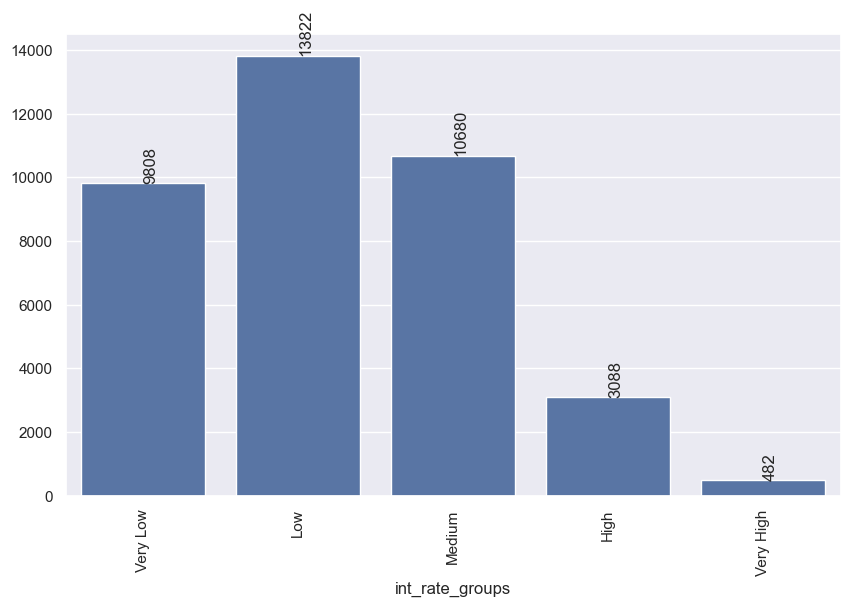

Low : 36.5 %
Medium : 28.2 %
Very Low : 25.9 %
High : 8.2 %
Very High : 1.3 %


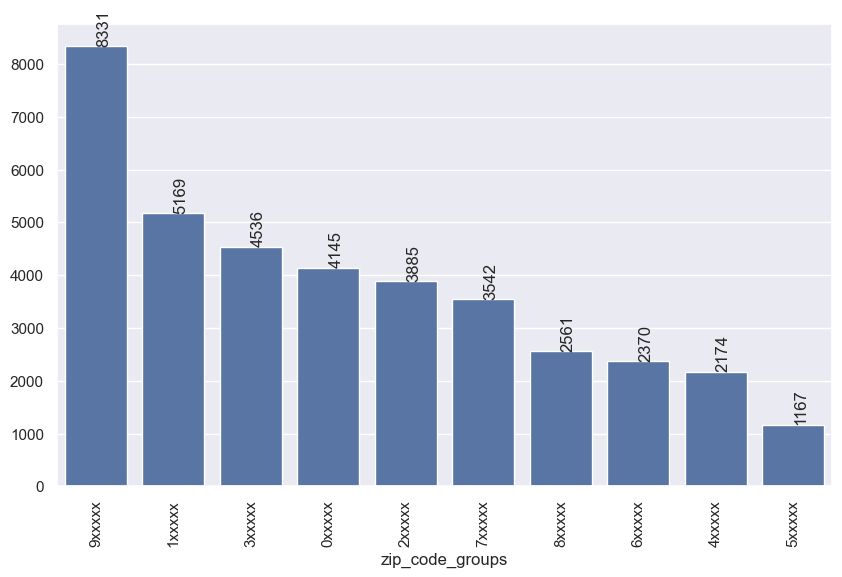

9xxxxx : 22.0 %
1xxxxx : 13.6 %
3xxxxx : 12.0 %
0xxxxx : 10.9 %
2xxxxx : 10.3 %
7xxxxx : 9.4 %
8xxxxx : 6.8 %
6xxxxx : 6.3 %
4xxxxx : 5.7 %
5xxxxx : 3.1 %


In [74]:
for item in ['issue_m', 'loan_amnt_groups','dti_groups', 'annual_inc_groups', 'int_rate_groups','zip_code_groups']:
    plot_bar_graph(df[item])

1) Most of the loans are issued in the second half of the year. December is the highest month where loans are issued which contributing to 10.9%.
2) loan amount in between 5k to 10k contribute to 32.6% of the total loan amount.
3) Among loan participants who charged off, most of the loan applications have the high DTI  ration. The lending company should implement 
strict DTI ratio requirements to prevent lending to individuals with unsustainable levels of debt relative to their income. 
4) 45% of loan applicants had annual salaries of 0 to 40K and 80k+. Out of which the charged off applicants are under the income group of 0 to 40k. Hence
it is always recommended to calculate the repayment ability of the applicant  
5) 36.5 % of loan applicants belong to low interest rate groups. It is also observed that where interest rate is medium are having more defaulters. It is
advisable to reduce the interest rate in order to get the loan retrieved 

# Bivariate Analysis

In this section, we will check how various attribites are related to loan amount, anual income

#### Related to grade

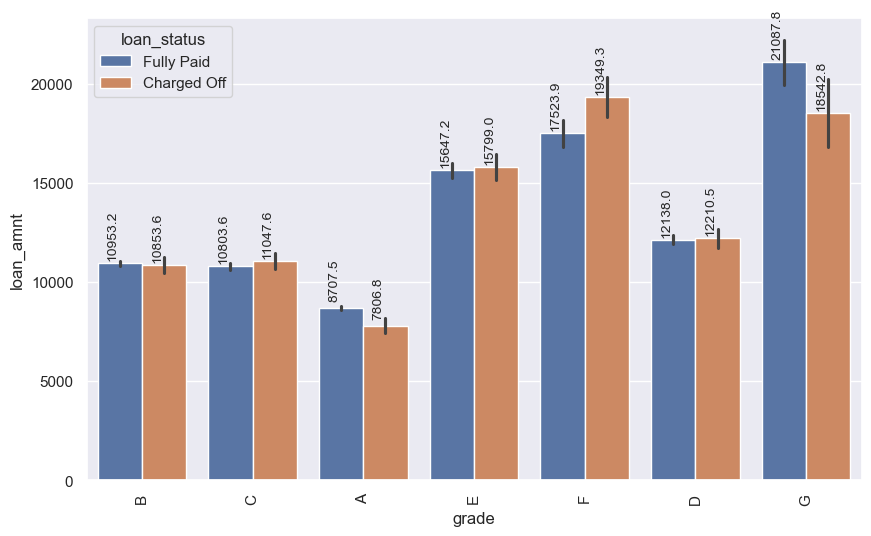

In [75]:
plot_bar_graph_with_cols (df,x_column='grade', y_column='loan_amnt', hue_column ='loan_status')

Across all the grades "Charged off" loans are almost equal to "Full paid" loans. Therefore we may need to look into additional factors to get more insights 

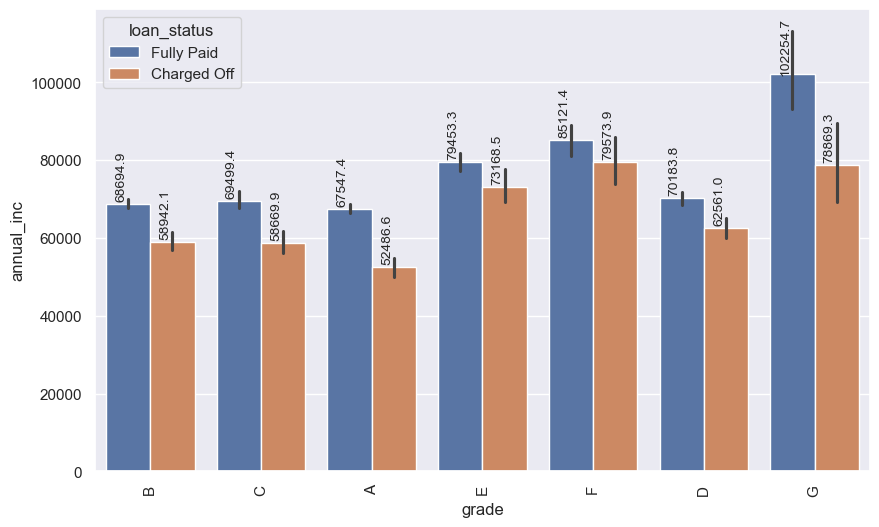

In [76]:
plot_bar_graph_with_cols (df,x_column='grade', y_column='annual_inc', hue_column ='loan_status')

For each grade, the annual income of the applicants with "Fully paid" loans is generally higher than those with charged off loans. This shows us
that higher income applicants are more likely to repay their loans fully.

#### Related to home owership

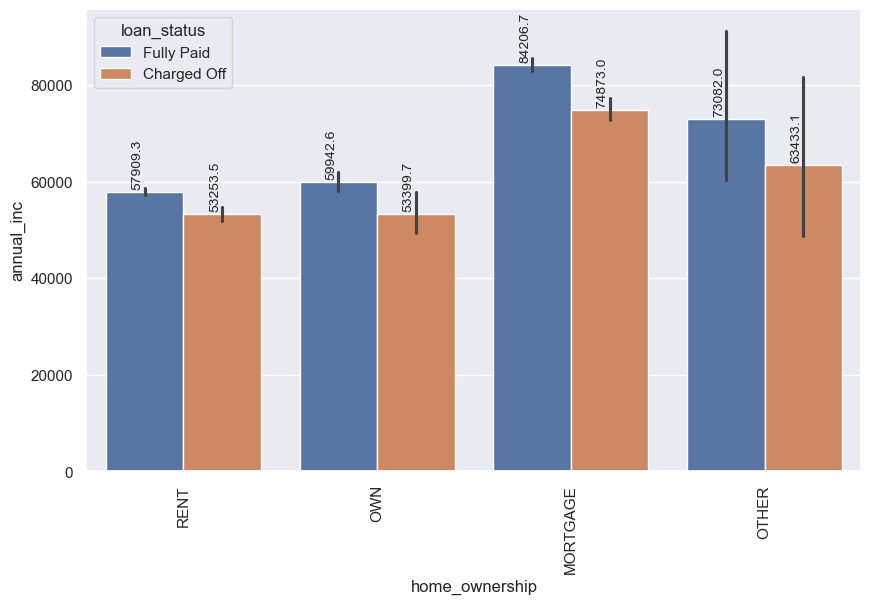

In [77]:
plot_bar_graph_with_cols (df,x_column='home_ownership', y_column='annual_inc', hue_column ='loan_status')

* Fully paid applicants have higher annual income when compared to charged off employees.
* Applicants under RENT have the lowest annual income.
* The significant difference in annual income can be clearly seen for certain categories like Mortgage and Rent.

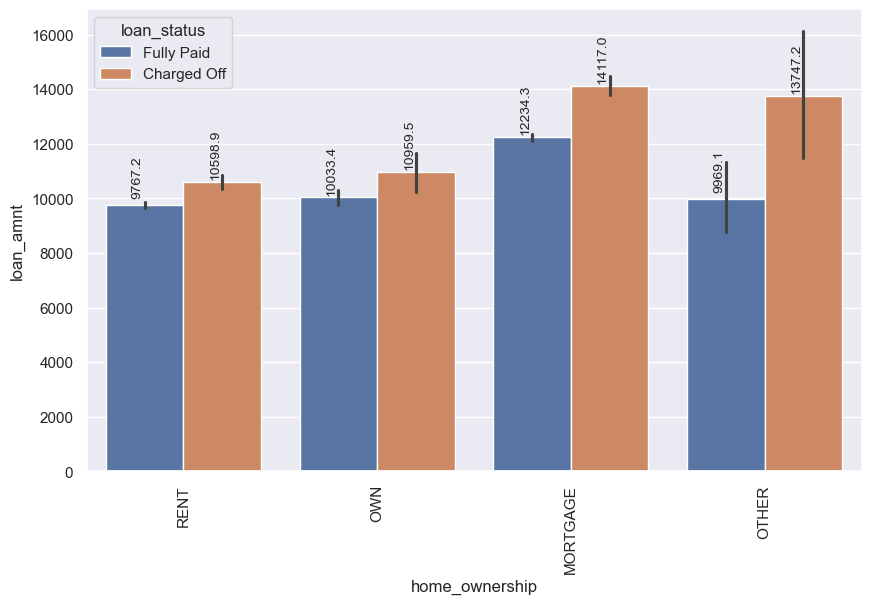

In [78]:
plot_bar_graph_with_cols (df,x_column='home_ownership', y_column='loan_amnt', hue_column ='loan_status')

* Charged off loans  generally have higher loan amounts compared to Fully paid loans
* Applicants under Rent category have lowest average loan amounts, regardless of loan status.
* Applicants under Mortgage and Other category tend to take larger loans which may increase in defaulters.

#### Related to verification status

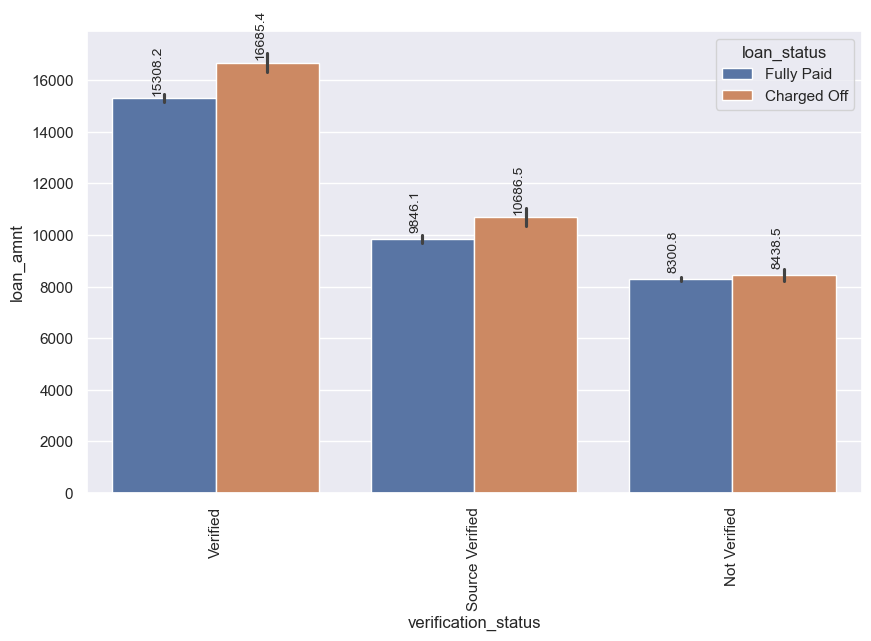

In [79]:
plot_bar_graph_with_cols (df,x_column='verification_status', y_column='loan_amnt', hue_column ='loan_status')

* Among all the verification status, charged off loans has higher loan amounts when compared to fully paid loans.
* Applicants with verification status "Verified" tend have higher loan amounts
* Applicants with verification status "Not Verified" have lower loan amounts may be due to limitations by lending company.

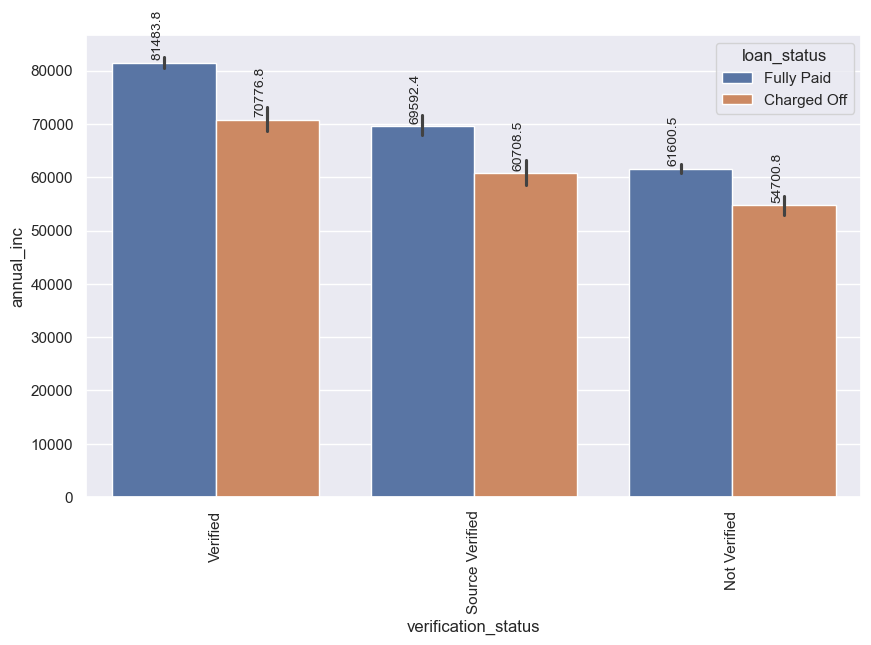

In [80]:
plot_bar_graph_with_cols (df,x_column='verification_status', y_column='annual_inc', hue_column ='loan_status')

Data pointers:
1) Loans with higher annual income are likely to be repaid more when compared to other status.
2) Applicants with Not Verified status have highest proportion with charged off loans.

#### Related to Term

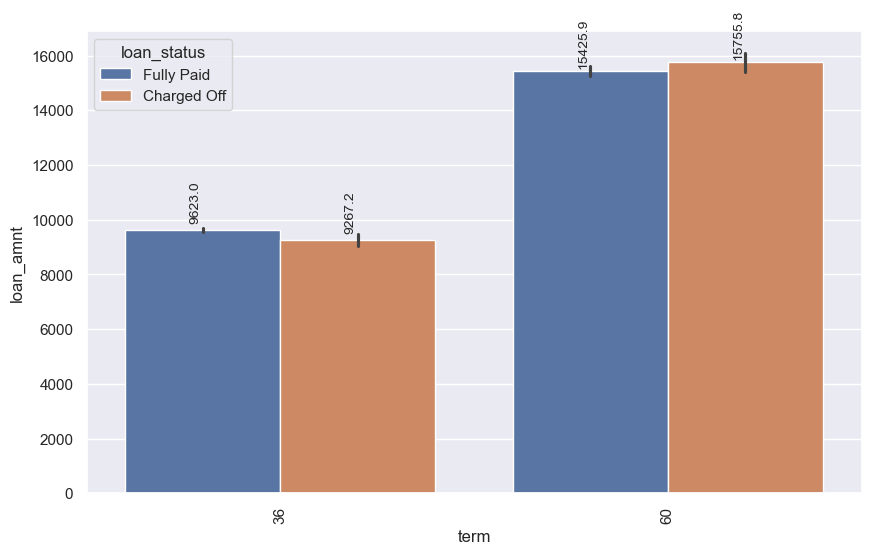

In [81]:
plot_bar_graph_with_cols (df,x_column='term', y_column='loan_amnt', hue_column ='loan_status')

Data pointers:
* The longer loan terms are associated with higher loan amounts and higher risk of repayment.

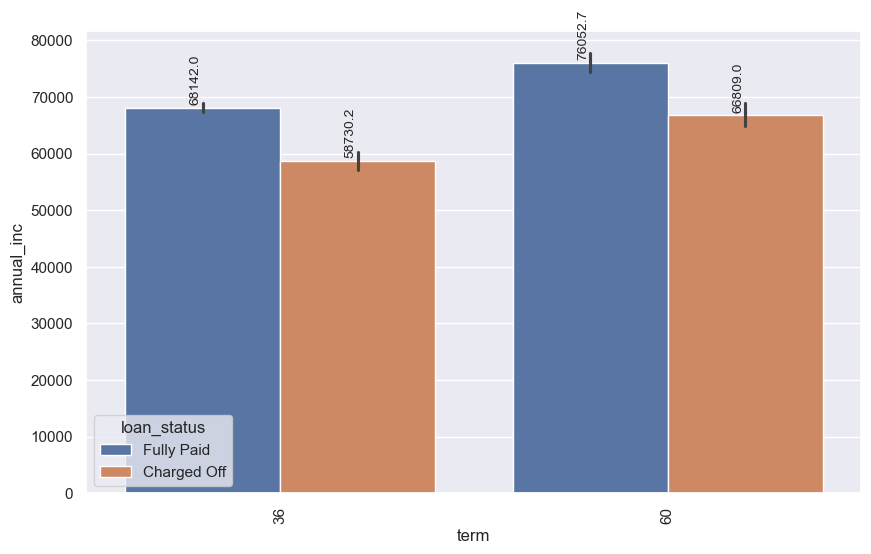

In [82]:
plot_bar_graph_with_cols (df,x_column='term', y_column='annual_inc', hue_column ='loan_status')

Data pointers:
* Across both the terms applicants with higher annual income appear to repay the loans in higher numbers where Applicants with lower annual
income tend to be defaulters.

#### Related to Zip Code

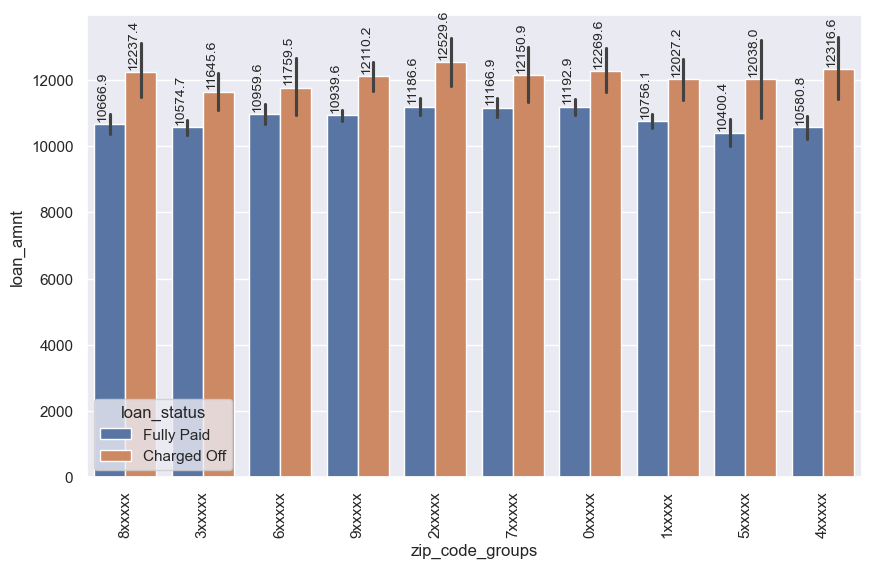

In [83]:
plot_bar_graph_with_cols (df,x_column='zip_code_groups', y_column='loan_amnt', hue_column ='loan_status')

Data pointers:
1) There is no significant difference in average loan amounts between two categories in most of the zip code groups
2) The loan amount distribution seems to be slightly same among all the zip codes. So it suggests loan amount distribution is not impacted by zip_code_groups

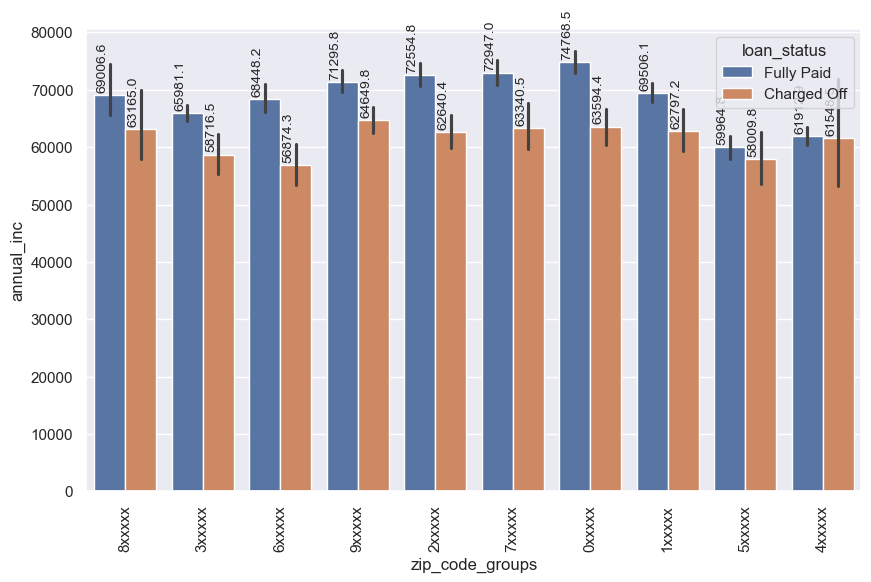

In [84]:
plot_bar_graph_with_cols (df,x_column='zip_code_groups', y_column='annual_inc', hue_column ='loan_status')

Data pointers:
1) Applicants categorized as "Full paid" seems to have higher annual income when compared to "Charged off".
2) Only some zip code groups show higher Annual income. But, most of the Annual incomes seems to be same across all the zip_code_groups
3) Employees whose income is higher tend to pay the loans on time 

#### Related to Purpose

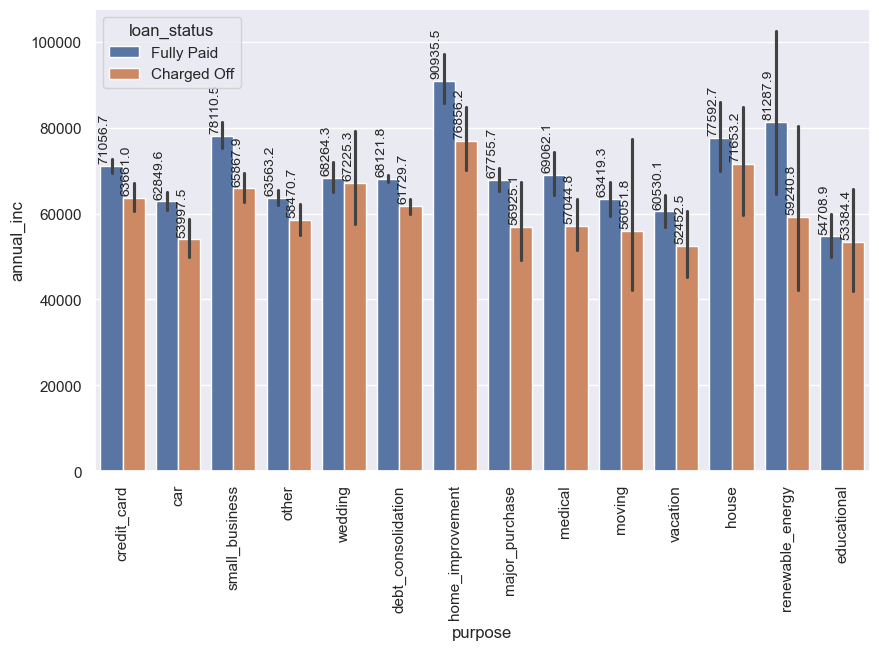

In [85]:
plot_bar_graph_with_cols (df,x_column='purpose', y_column='annual_inc', hue_column ='loan_status')

Data Pointers:
1) Higher Annual income correlates with higher chances of reducing the defaulters
2) Purpose like small_business and medical show the notable differences, where charged off loans are linked to income 

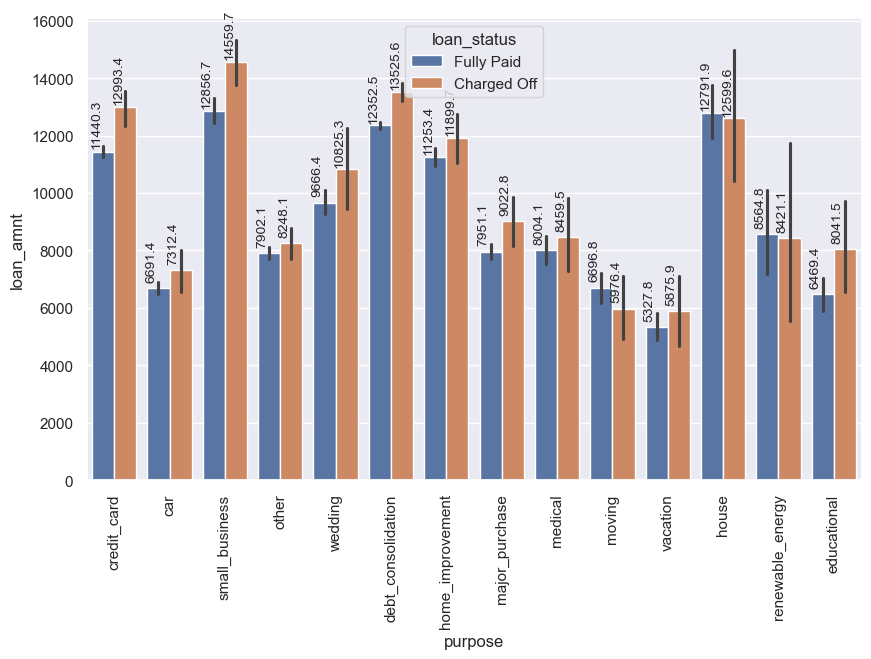

In [86]:
plot_bar_graph_with_cols (df,x_column='purpose', y_column='loan_amnt', hue_column ='loan_status')

Data pointers:
1) Credit_card loans have highest charged off rate when compared to others
2) Vacation loans have lesser charged off rate.

Recommendation:
1) Stricter rules has to be implemented while approving the loans for credit_cards

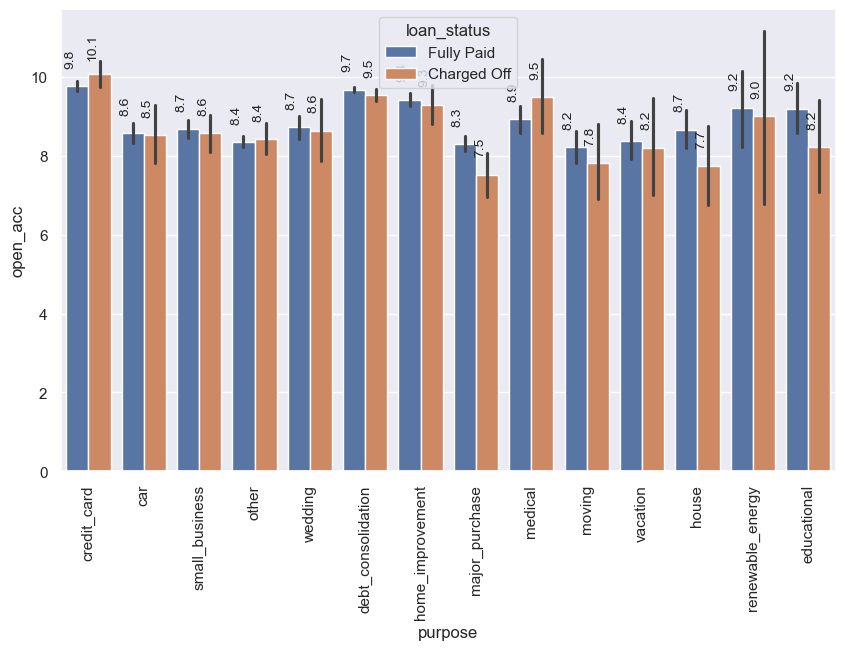

In [87]:
plot_bar_graph_with_cols (df,x_column='purpose', y_column='open_acc', hue_column ='loan_status')

Data pointer:
* Majority portion of loans have higher "Charged off" loans across all segments and credit card stands higher among them again.

#### Related to Annual Income as a group

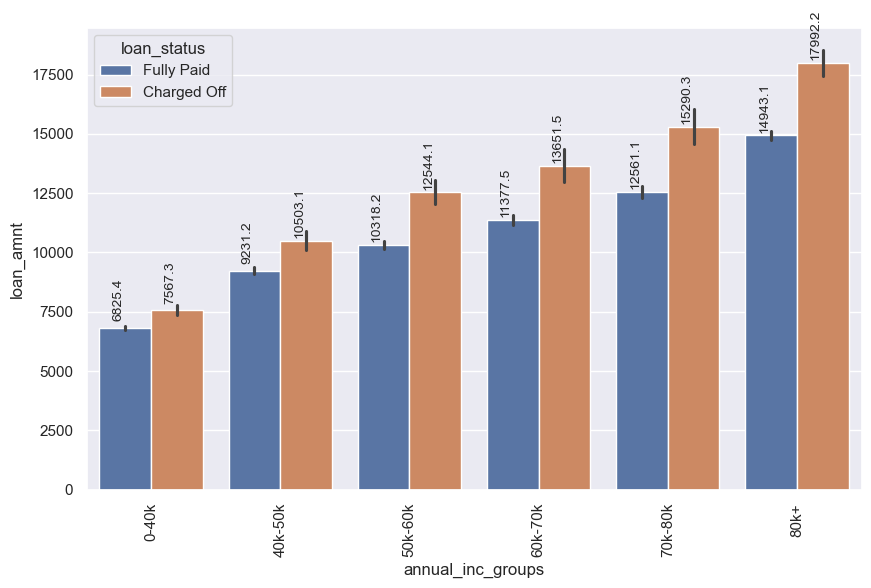

In [88]:
plot_bar_graph_with_cols (df,x_column='annual_inc_groups', y_column='loan_amnt', hue_column ='loan_status')

Data pointers:
* Plot shows us clearly that , "the higher the annual income, the higher the loan amount", so is the risk of default

#### Related to Employee length

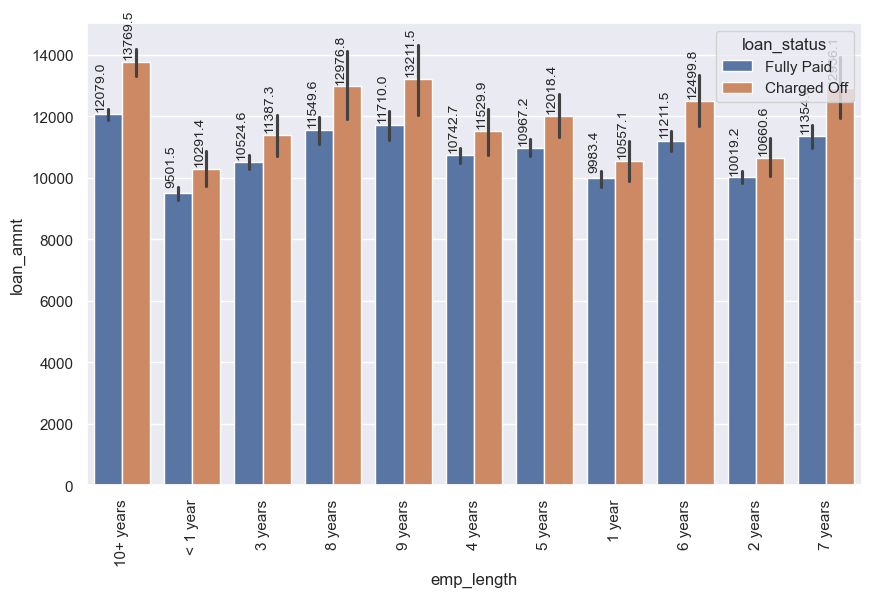

In [89]:
plot_bar_graph_with_cols (df,x_column='emp_length', y_column='loan_amnt', hue_column ='loan_status')

#### Related to Interest rates

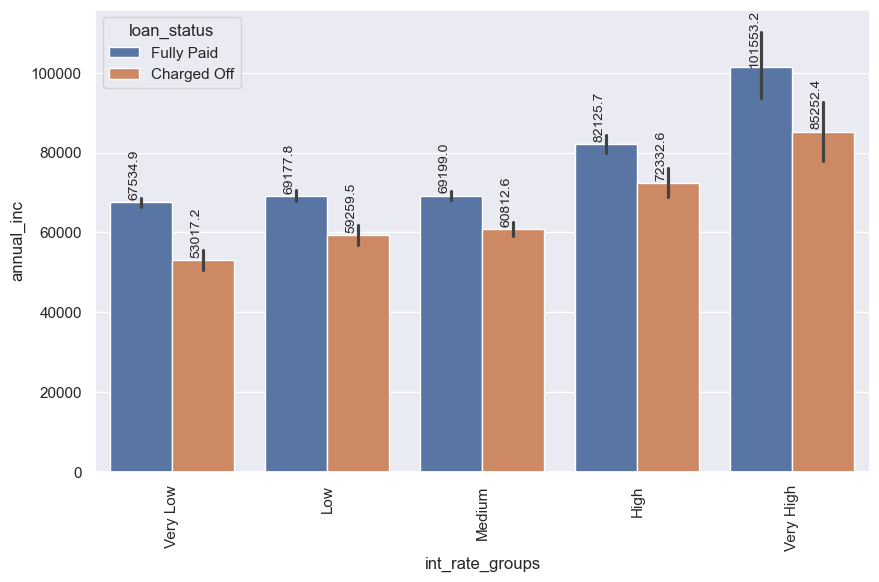

In [90]:
plot_bar_graph_with_cols (df,x_column='int_rate_groups', y_column='annual_inc', hue_column ='loan_status')

Data pointer:
1) Applicants with higher annual income tend to qualify for loans with higher interests.
2) As the interest rate increases the proportion of "charged off" loans also increases
                                                      

# Multivariate Analysis

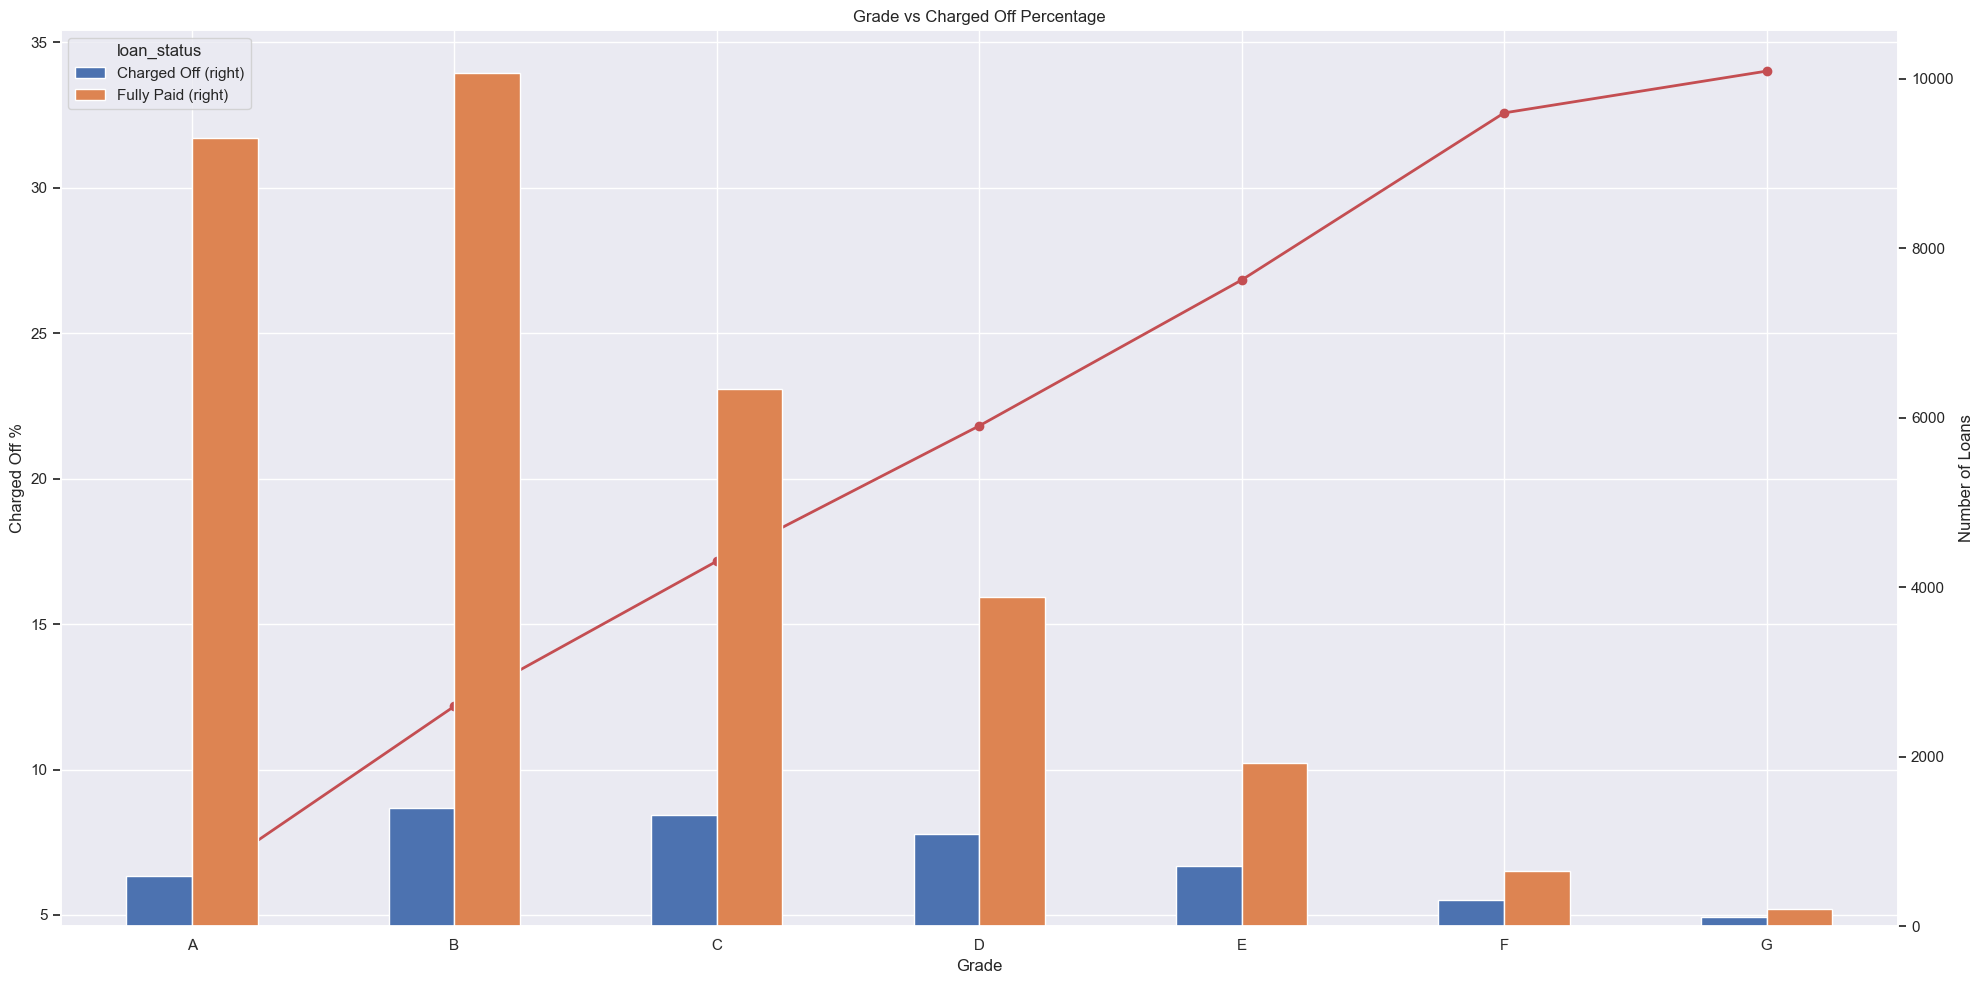

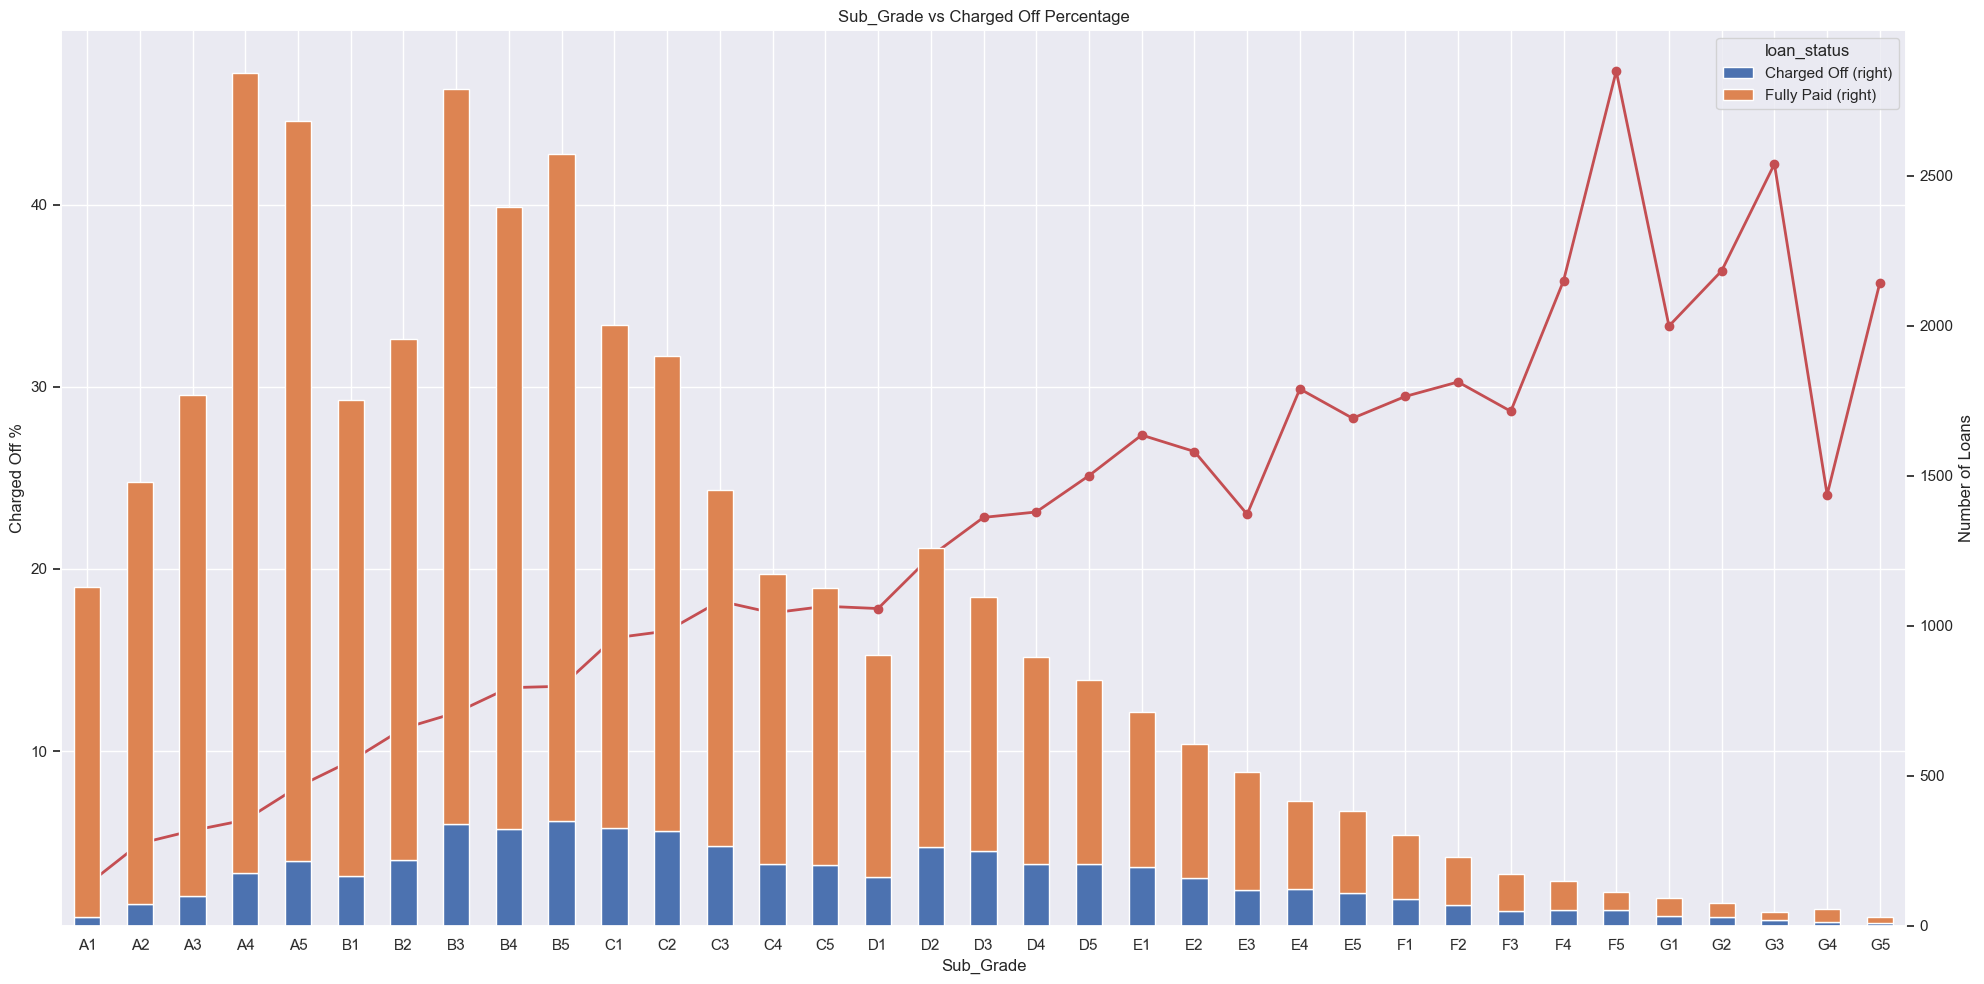

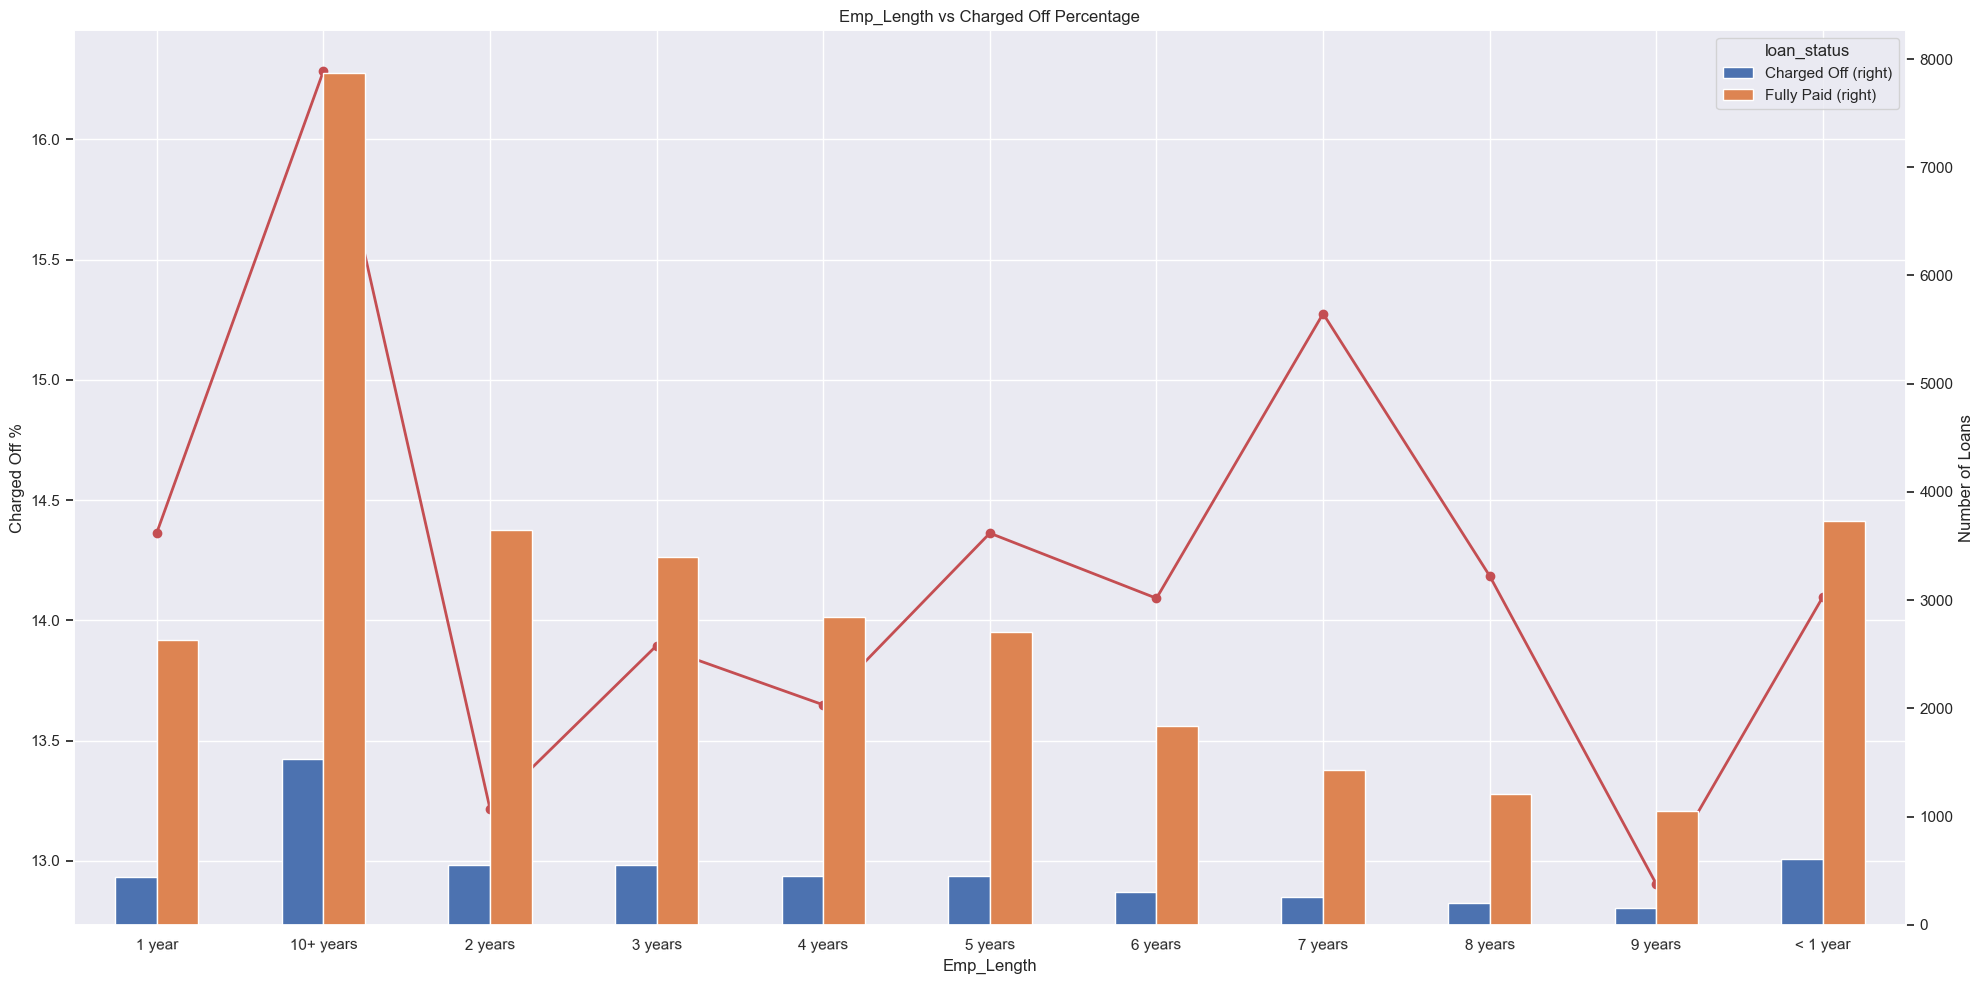

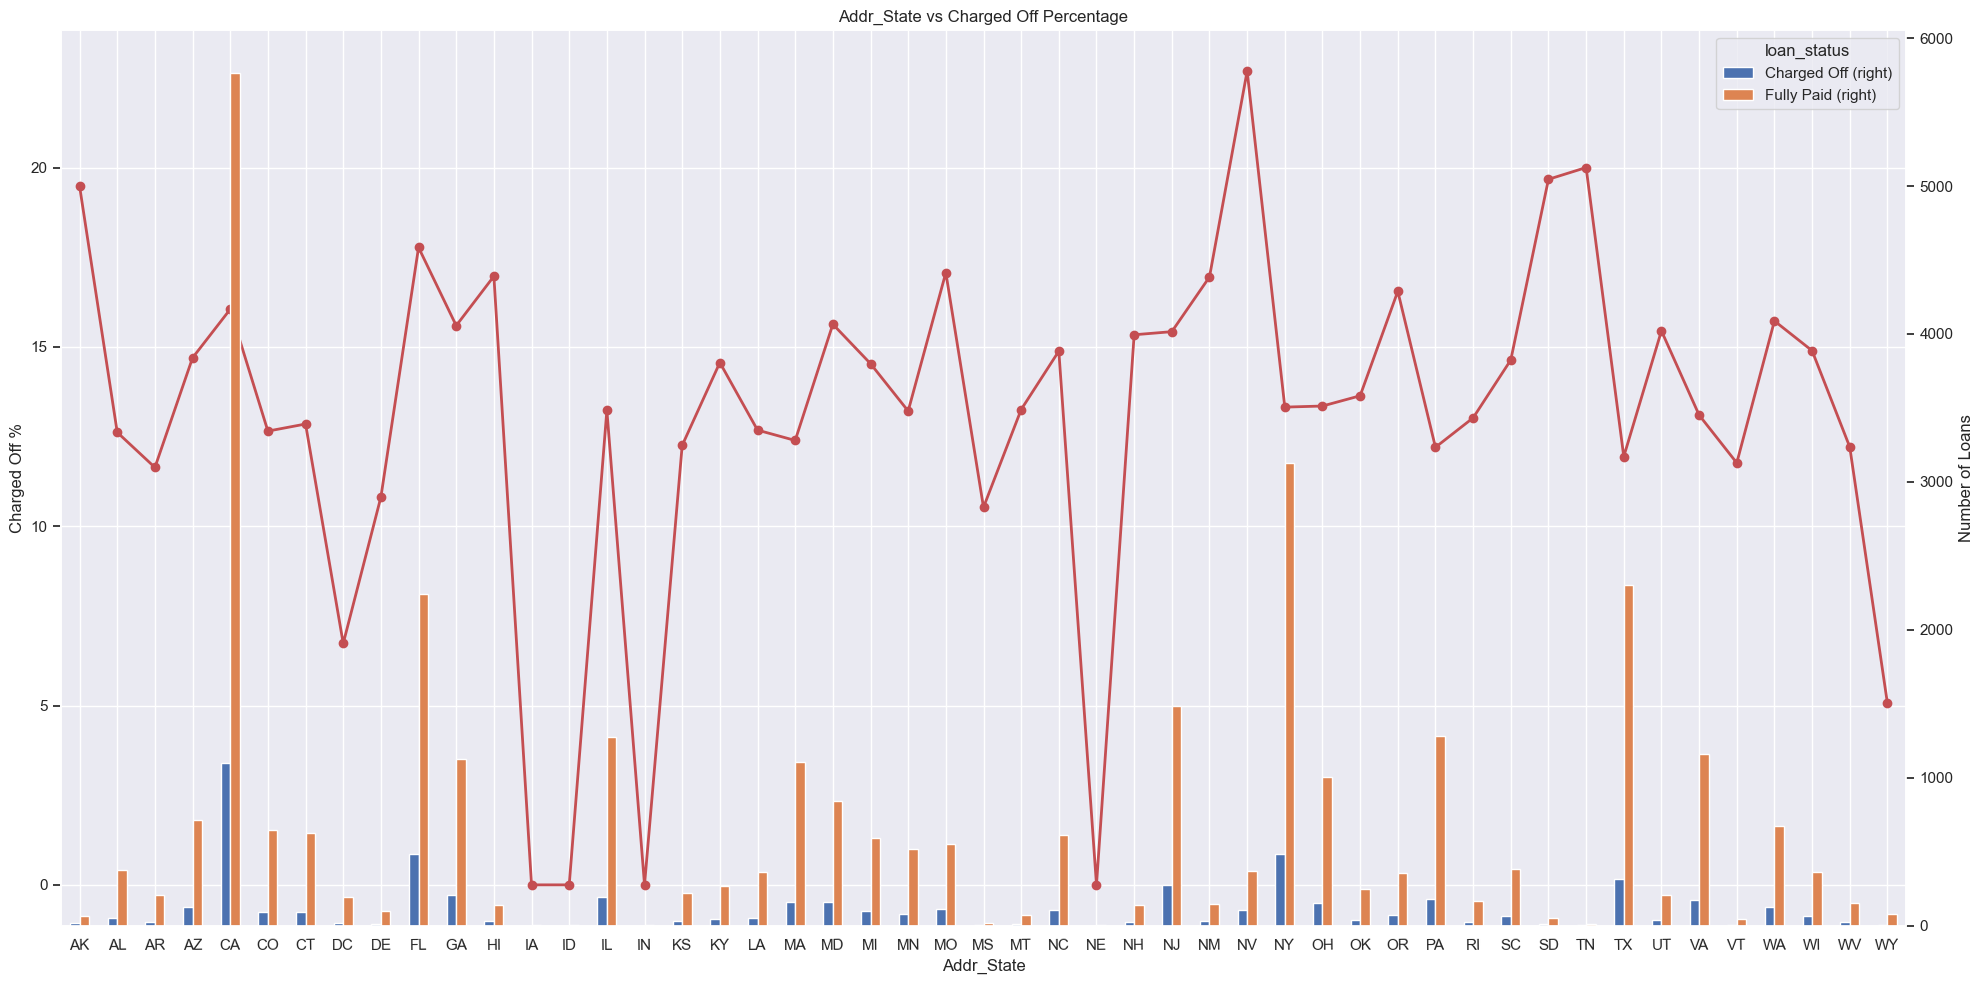

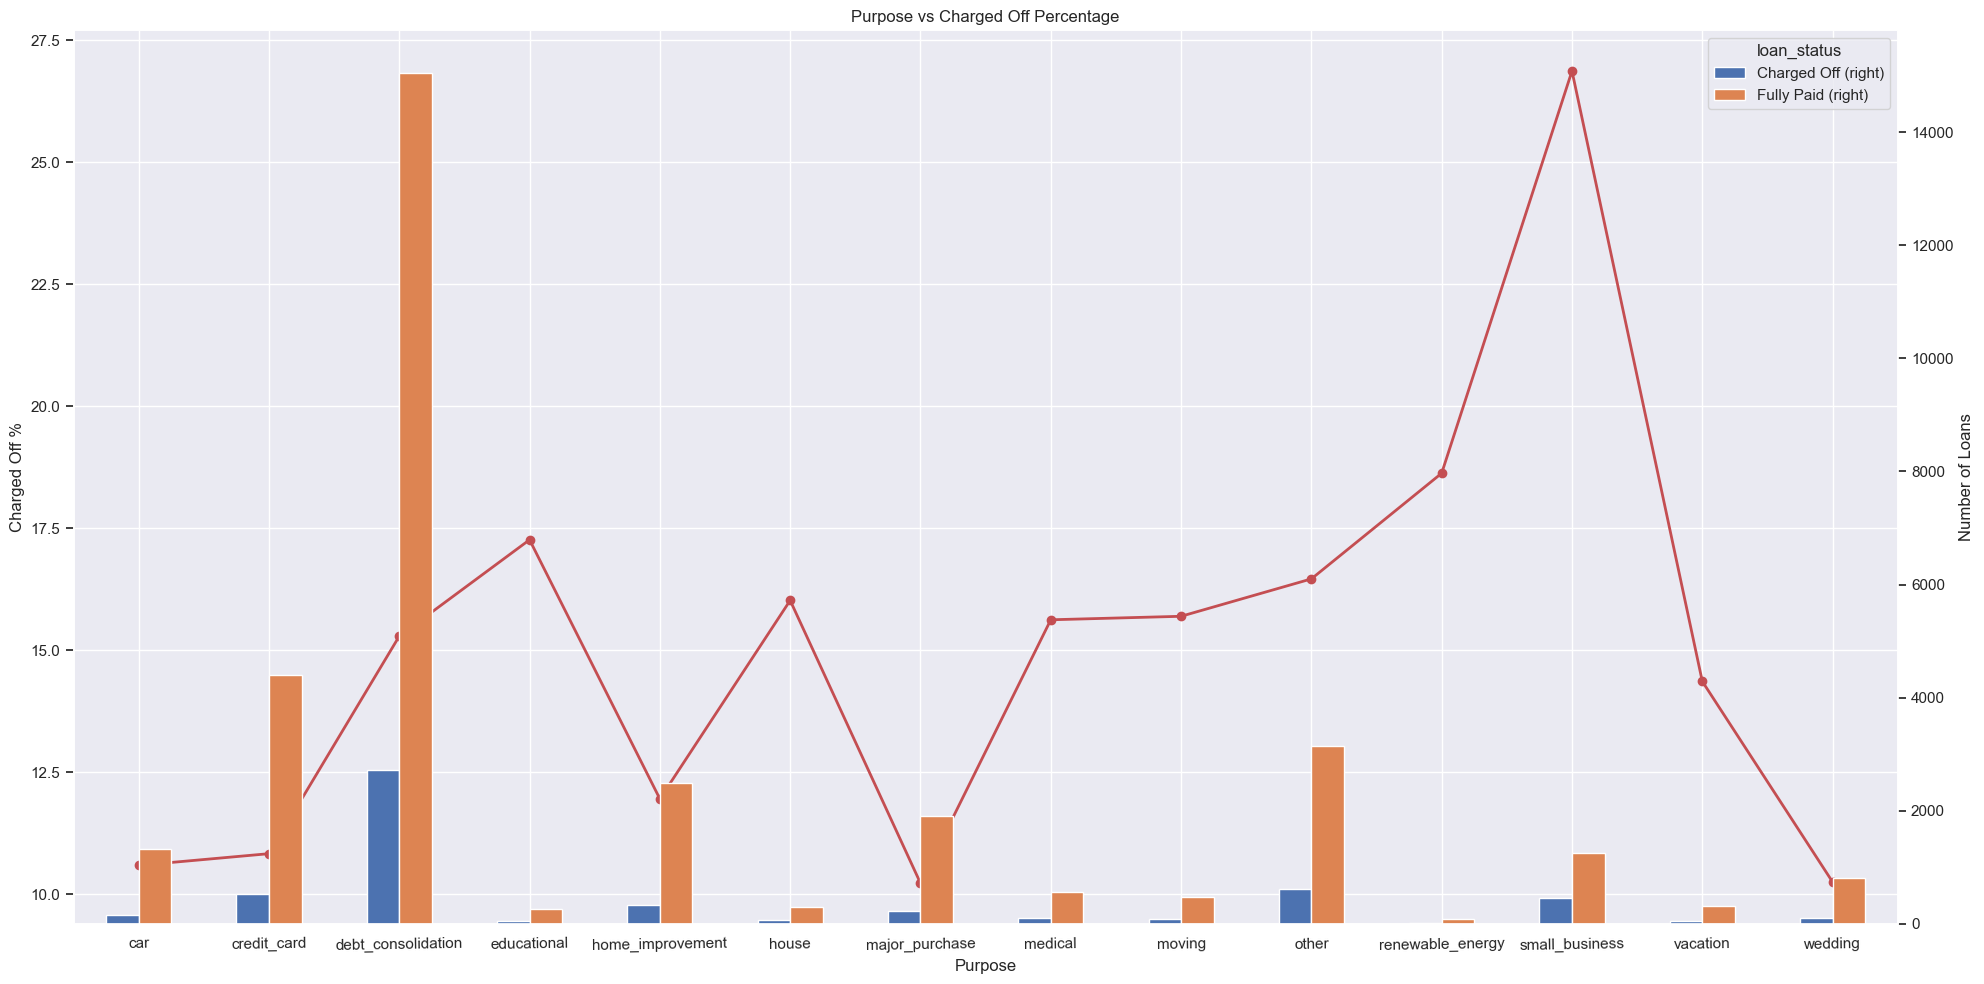

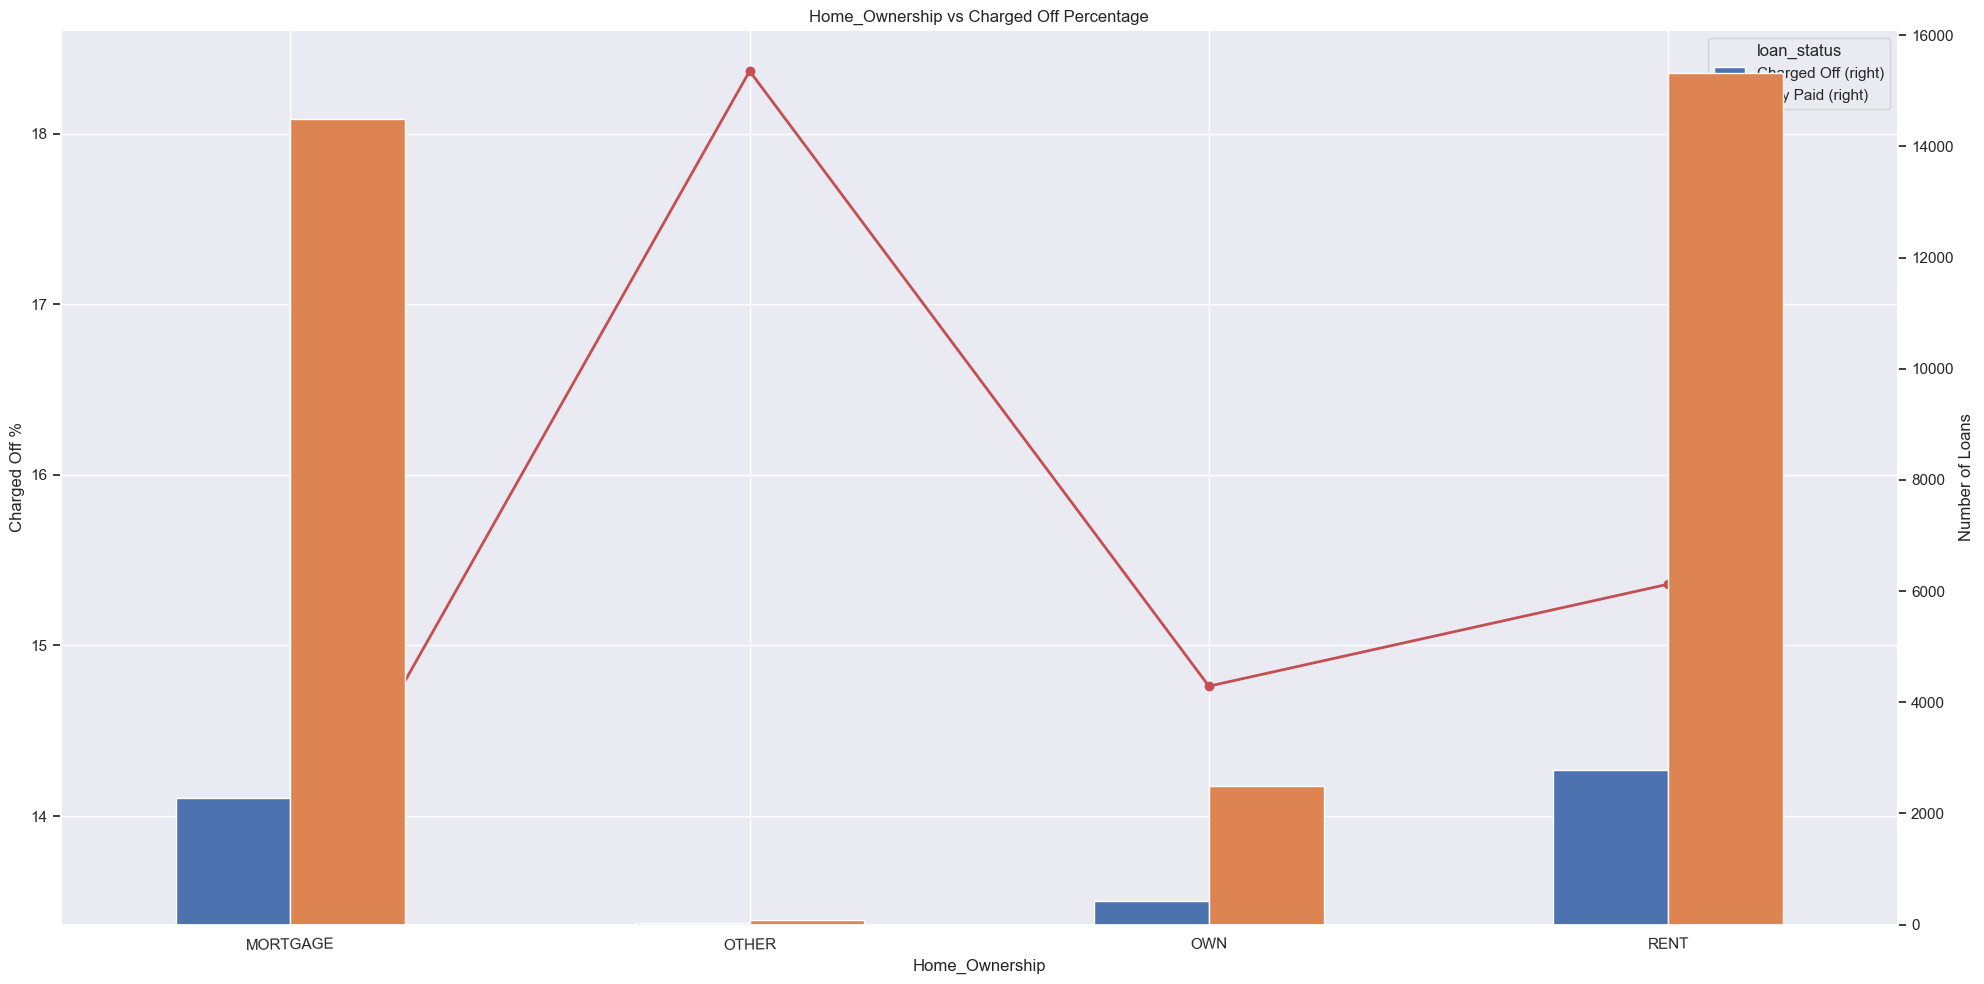

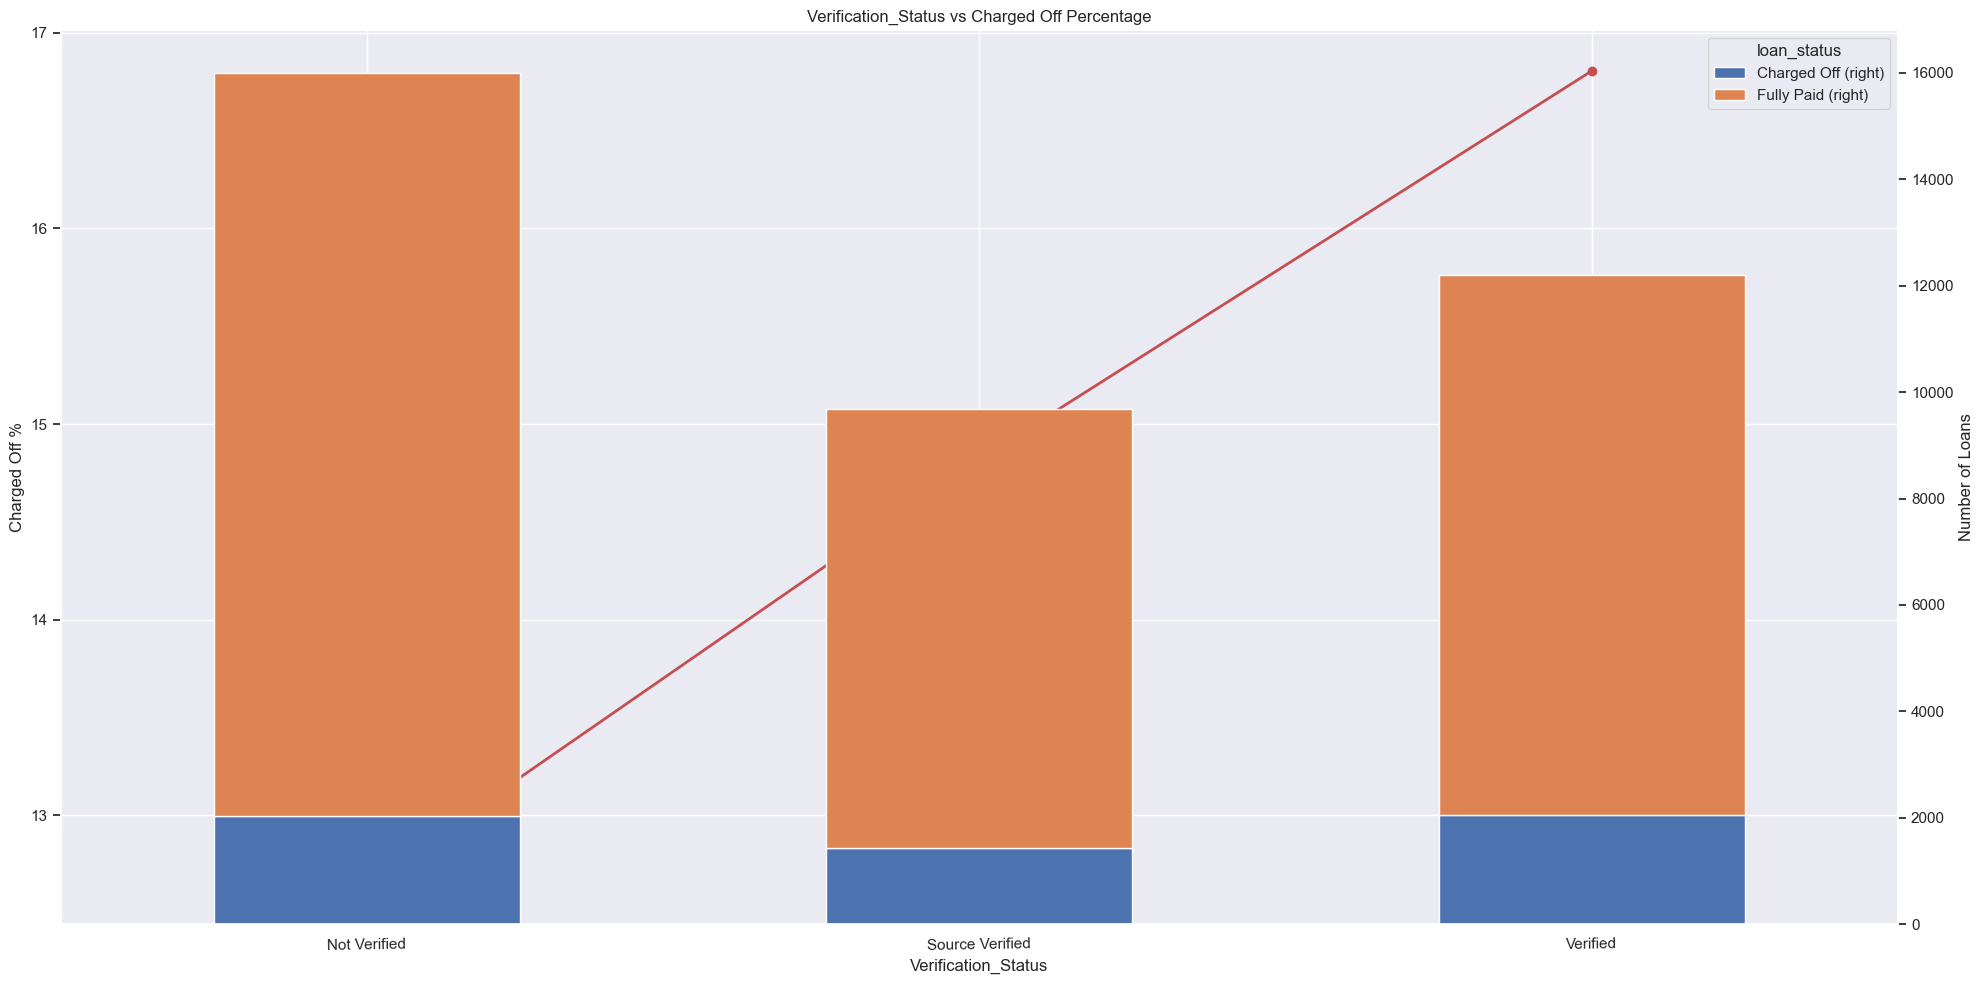

In [91]:
columns_to_config = {
    'grade': {},
    'sub_grade': {'stacked': True},
    'emp_length': {},
    'addr_state': {},
    'purpose': {},
    'home_ownership': {},
    'verification_status': {'stacked': True}
}

for column, plot_config in columns_to_config.items():
    stacked = plot_config.get('stacked', False)
    plot_charged_off_percentage(df, column, stacked)

Data pointers:
1) Tendency of defaulters increase in the B,C,D grades
2) Subgrades B3,B4,B5 have high defaulters
3) Employees with 10+ years of service tend to more defaulters
4) Applicants from states 'CA','FL' and 'NJ' have more number of defaulters.
5) Applicants for debt consolidation have high tendency to default loan.
6) Applicants from Rented House Ownership have highest tendency to default the loan.
7) Applicants with Verified and Not Verified status has high tendency to default.

# Correlation Analysis

In [92]:
correlation_df = df.copy()
# Dropping issue_m which is irrelavant to analysis 
correlation_df = correlation_df.drop( 'issue_m', axis = 1)

In [93]:
correlation_df.dtypes


loan_amnt                        int64
funded_amnt                      int64
term                             int64
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                     object
purpose                         object
zip_code                        object
addr_state                      object
dti                            float64
inq_last_6mths                   int64
open_acc                         int64
pub_rec                          int64
total_acc                        int64
last_credit_pull_d              object
pub_rec_bankruptcies           float64
loan_amnt_groups              category
dti_groups                    category
int_rate_groups          

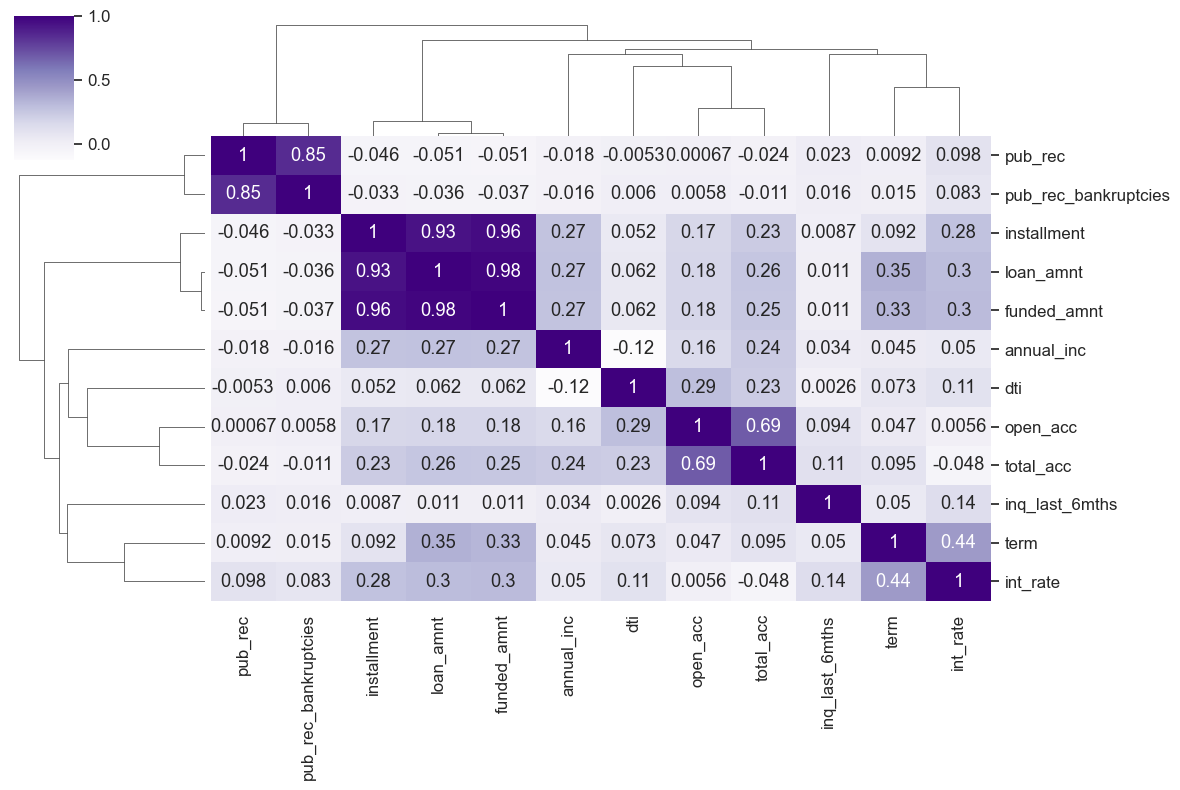

In [94]:
numeric_df = correlation_df.select_dtypes(include=[float, int])

# Now calculate the correlation matrix
corr = numeric_df.corr()

# Proceed with the clustermap
sns.set(font_scale=1.1)
sns.clustermap(corr, annot=True, figsize=(12, 8), cmap="Purples")
plt.show()

Data points:

Strong correlation observed between:
* 'installment' with loan_amnt, funded_amnt.
* interest rate with term.
* annual income with loan amount

Negative correlation observed between:
* pub_rec_bankrupticies and loan amount
* annual_inc and dti